In [1]:
"""
===============================================================================
FINANCIAL OPERATIONS ANALYTICS PROJECT
===============================================================================

Project: Revenue Forecasting, Churn & Profitability Analysis

Analytics Covered:
- Time Series Analysis (ARIMA, Prophet, Exponential Smoothing)
- Regression Analysis (Linear, Logistic, Random Forest)
- Cohort & Retention Analysis
- Customer Lifetime Value (CLV)
- RFM Segmentation
- Survival Analysis

Python Version: 3.7+
===============================================================================
"""

# ============================================================================
# SECTION 0: ENVIRONMENT SETUP & LIBRARY IMPORTS
# ============================================================================

print("""
╔══════════════════════════════════════════════════════════════════════════╗
║                FINANCIAL OPERATIONS ANALYTICS PROJECT                     ║
║         Revenue Forecasting | Churn Analysis | Profitability             ║
╚══════════════════════════════════════════════════════════════════════════╝
""")

# Core data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Statistical analysis
from scipy import stats
from scipy.stats import normaltest, kstest
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

# Time series forecasting
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError:
    print("Prophet not available. Install with: pip install prophet")
    PROPHET_AVAILABLE = False

# Utilities
import os
import json
from collections import defaultdict

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")


╔══════════════════════════════════════════════════════════════════════════╗
║                FINANCIAL OPERATIONS ANALYTICS PROJECT                     ║
║         Revenue Forecasting | Churn Analysis | Profitability             ║
╚══════════════════════════════════════════════════════════════════════════╝

Prophet not available. Install with: pip install prophet
All libraries imported successfully!
Analysis started at: 2026-02-10 20:47:54



In [2]:
# ============================================================================
# SECTION 1: SYNTHETIC DATA GENERATION
# ============================================================================

"""
we'll generate realistic synthetic financial data that mimics real-world patterns:

1. Customer transactions (SaaS subscription data)
2. Customer information
3. Revenue records
4. Churn events
"""

print("="*80)
print("SECTION 1: DATA GENERATION")
print("="*80)
print("\n Generating synthetic financial dataset...")
print("This simulates a SaaS/subscription business with realistic patterns.\n")

def generate_financial_data(
    n_customers=5000,
    start_date='2020-01-01',
    end_date='2024-12-31',
    random_seed=42
):
    """
    Generate comprehensive synthetic financial dataset
    
    Parameters:
    -----------
    n_customers : int
        Number of unique customers to generate
    start_date : str
        Start date for transaction history
    end_date : str
        End date for transaction history
    random_seed : int
        Random seed for reproducibility
    
    Returns:
    --------
    dict : Dictionary containing multiple DataFrames
        - customers: Customer master data
        - transactions: All customer transactions
        - monthly_revenue: Aggregated monthly revenue
    """
    
    np.random.seed(random_seed)
    
    # Date range
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    date_range = pd.date_range(start, end, freq='D')
    
    print(f"Generating data for {n_customers:,} customers...")
    print(f"Date range: {start_date} to {end_date}")
    print(f"Total days: {len(date_range):,}\n")
    
    # ========================================================================
    # 1. GENERATE CUSTOMER MASTER DATA
    # ========================================================================
    
    print("Creating customer master data...")
    
    # Customer segments (realistic distribution)
    segments = ['Enterprise', 'Mid-Market', 'Small Business', 'Startup']
    segment_weights = [0.10, 0.25, 0.40, 0.25]
    
    # Customer industries
    industries = [
        'Technology', 'Healthcare', 'Finance', 'Retail', 
        'Manufacturing', 'Education', 'Real Estate', 'Other'
    ]
    industry_weights = [0.25, 0.15, 0.15, 0.12, 0.10, 0.08, 0.08, 0.07]
    
    # Subscription plans
    plans = ['Basic', 'Professional', 'Business', 'Enterprise']
    plan_prices = {
        'Basic': 49,
        'Professional': 149,
        'Business': 399,
        'Enterprise': 999
    }
    
    customers_data = {
        'customer_id': [f'CUST_{i:06d}' for i in range(1, n_customers + 1)],
        'signup_date': pd.to_datetime([
            start + timedelta(days=np.random.randint(0, (end - start).days))
            for _ in range(n_customers)
        ]),
        'segment': np.random.choice(segments, n_customers, p=segment_weights),
        'industry': np.random.choice(industries, n_customers, p=industry_weights),
        'country': np.random.choice(
            ['USA', 'UK', 'Canada', 'Germany', 'France', 'Australia', 'Other'],
            n_customers,
            p=[0.40, 0.15, 0.10, 0.10, 0.08, 0.07, 0.10]
        ),
        'plan': np.random.choice(plans, n_customers, p=[0.35, 0.30, 0.25, 0.10]),
    }
    
    customers_df = pd.DataFrame(customers_data)
    
    # Add monthly recurring revenue (MRR) based on plan
    customers_df['mrr'] = customers_df['plan'].map(plan_prices)
    
    # Add features that correlate with churn
    customers_df['contract_length'] = np.random.choice(
        [1, 12, 24, 36],  # months
        n_customers,
        p=[0.30, 0.40, 0.20, 0.10]
    )
    
    # Number of users (seats)
    customers_df['number_of_users'] = np.where(
        customers_df['segment'] == 'Enterprise',
        np.random.randint(50, 500, n_customers),
        np.where(
            customers_df['segment'] == 'Mid-Market',
            np.random.randint(10, 50, n_customers),
            np.where(
                customers_df['segment'] == 'Small Business',
                np.random.randint(2, 10, n_customers),
                np.random.randint(1, 5, n_customers)
            )
        )
    )
    
    # Support tickets (indicator of satisfaction)
    customers_df['support_tickets'] = np.random.poisson(
        lam=2, size=n_customers
    )
    
    # Product usage score (0-100)
    customers_df['usage_score'] = np.clip(
        np.random.normal(65, 20, n_customers),
        0, 100
    ).astype(int)
    
    # NPS score (-100 to 100)
    customers_df['nps_score'] = np.clip(
        np.random.normal(30, 40, n_customers),
        -100, 100
    ).astype(int)
    
    print(f"   ✓ Generated {len(customers_df):,} customer records")
    
    # ========================================================================
    # 2. GENERATE TRANSACTION HISTORY
    # ========================================================================
    
    print("Creating transaction history...")
    
    transactions_list = []
    
    for idx, customer in customers_df.iterrows():
        customer_id = customer['customer_id']
        signup = customer['signup_date']
        mrr = customer['mrr']
        usage_score = customer['usage_score']
        
        # Determine if customer will churn and when
        # Lower usage score = higher churn probability
        churn_probability = max(0.05, (100 - usage_score) / 200)
        will_churn = np.random.random() < churn_probability
        
        if will_churn:
            # Churn somewhere between 3 months and 2 years after signup
            days_to_churn = np.random.randint(90, 730)
            churn_date = signup + timedelta(days=days_to_churn)
            if churn_date > end:
                churn_date = end
        else:
            churn_date = end
        
        # Generate monthly transactions
        current_date = signup
        transaction_num = 1
        
        while current_date <= churn_date and current_date <= end:
            # Add some randomness to payment amounts (upgrades, discounts, etc.)
            amount_variation = np.random.uniform(0.90, 1.10)
            amount = mrr * amount_variation
            
            # Occasional expansion revenue (upsells)
            if np.random.random() < 0.05:  # 5% chance of upsell
                amount *= np.random.uniform(1.2, 1.5)
            
            transactions_list.append({
                'transaction_id': f'{customer_id}_TXN_{transaction_num:04d}',
                'customer_id': customer_id,
                'transaction_date': current_date,
                'amount': round(amount, 2),
                'transaction_type': 'Subscription' if transaction_num > 1 else 'New',
                'status': 'Completed',
                'payment_method': np.random.choice(
                    ['Credit Card', 'ACH', 'Wire Transfer', 'PayPal'],
                    p=[0.60, 0.20, 0.15, 0.05]
                )
            })
            
            # Move to next month
            current_date = current_date + pd.DateOffset(months=1)
            transaction_num += 1
        
        # Add churn event if applicable
        if will_churn and churn_date < end:
            customers_df.loc[idx, 'churn_date'] = churn_date
            customers_df.loc[idx, 'is_churned'] = 1
        else:
            customers_df.loc[idx, 'churn_date'] = pd.NaT
            customers_df.loc[idx, 'is_churned'] = 0
    
    transactions_df = pd.DataFrame(transactions_list)
    
    print(f"   ✓ Generated {len(transactions_df):,} transactions")
    
    # ========================================================================
    # 3. AGGREGATE MONTHLY REVENUE
    # ========================================================================
    
    print("Aggregating monthly revenue...")
    
    transactions_df['year_month'] = transactions_df['transaction_date'].dt.to_period('M')
    
    monthly_revenue = transactions_df.groupby('year_month').agg({
        'amount': ['sum', 'count', 'mean'],
        'customer_id': 'nunique'
    }).reset_index()
    
    monthly_revenue.columns = [
        'year_month', 'total_revenue', 'num_transactions', 
        'avg_transaction', 'unique_customers'
    ]
    
    monthly_revenue['year_month'] = monthly_revenue['year_month'].dt.to_timestamp()
    
    # Add growth rate
    monthly_revenue['revenue_growth'] = monthly_revenue['total_revenue'].pct_change() * 100
    
    # Add seasonality (holiday seasons tend to have higher revenue)
    monthly_revenue['month'] = monthly_revenue['year_month'].dt.month
    monthly_revenue['quarter'] = monthly_revenue['year_month'].dt.quarter
    monthly_revenue['is_q4'] = (monthly_revenue['quarter'] == 4).astype(int)
    
    print(f"   ✓ Aggregated to {len(monthly_revenue)} monthly periods")
    
    # ========================================================================
    # 4. CALCULATE ADDITIONAL CUSTOMER METRICS
    # ========================================================================
    
    print("Calculating customer metrics...")
    
    # Customer lifetime (months)
    customers_df['lifetime_months'] = (
        (customers_df['churn_date'].fillna(end) - customers_df['signup_date']).dt.days / 30
    ).round(1)
    
    # Total revenue per customer
    customer_revenue = transactions_df.groupby('customer_id')['amount'].sum().reset_index()
    customer_revenue.columns = ['customer_id', 'total_revenue']
    customers_df = customers_df.merge(customer_revenue, on='customer_id', how='left')
    
    # Customer Lifetime Value (CLV)
    customers_df['clv'] = customers_df['total_revenue']
    
    # Recency (days since last transaction for churned customers)
    last_transaction = transactions_df.groupby('customer_id')['transaction_date'].max().reset_index()
    last_transaction.columns = ['customer_id', 'last_transaction_date']
    customers_df = customers_df.merge(last_transaction, on='customer_id', how='left')
    
    customers_df['recency_days'] = (
        end - customers_df['last_transaction_date']
    ).dt.days
    
    # Frequency (number of transactions)
    transaction_count = transactions_df.groupby('customer_id').size().reset_index()
    transaction_count.columns = ['customer_id', 'transaction_count']
    customers_df = customers_df.merge(transaction_count, on='customer_id', how='left')
    
    # Monetary (average transaction value)
    avg_transaction = transactions_df.groupby('customer_id')['amount'].mean().reset_index()
    avg_transaction.columns = ['customer_id', 'avg_transaction_value']
    customers_df = customers_df.merge(avg_transaction, on='customer_id', how='left')
    
    print(f"   ✓ Calculated lifetime value, RFM metrics, and more")
    
    # ========================================================================
    # 5. CREATE COHORT ANALYSIS DATA
    # ========================================================================
    
    print("Creating cohort structures...")
    
    # Add cohort month (signup month)
    customers_df['cohort_month'] = customers_df['signup_date'].dt.to_period('M')
    
    # Merge cohort info with transactions
    transactions_df = transactions_df.merge(
        customers_df[['customer_id', 'cohort_month']], 
        on='customer_id', 
        how='left'
    )
    
    transactions_df['transaction_month'] = transactions_df['transaction_date'].dt.to_period('M')
    
    print(f"   ✓ Cohort data prepared for retention analysis")
    
    # ========================================================================
    # SUMMARY STATISTICS
    # ========================================================================
    
    print("\n" + "="*80)
    print("DATA GENERATION SUMMARY")
    print("="*80)
    
    print(f"\n DATASET OVERVIEW:")
    print(f"   • Total Customers: {len(customers_df):,}")
    print(f"   • Total Transactions: {len(transactions_df):,}")
    print(f"   • Date Range: {start_date} to {end_date}")
    print(f"   • Time Periods: {len(monthly_revenue)} months")
    
    print(f"\n REVENUE METRICS:")
    print(f"   • Total Revenue: ${transactions_df['amount'].sum():,.2f}")
    print(f"   • Average MRR: ${customers_df['mrr'].mean():.2f}")
    print(f"   • Average CLV: ${customers_df['clv'].mean():,.2f}")
    
    print(f"\n CUSTOMER METRICS:")
    churned_count = customers_df['is_churned'].sum()
    churn_rate = (churned_count / len(customers_df)) * 100
    print(f"   • Active Customers: {len(customers_df) - churned_count:,}")
    print(f"   • Churned Customers: {churned_count:,}")
    print(f"   • Overall Churn Rate: {churn_rate:.1f}%")
    print(f"   • Avg Lifetime: {customers_df['lifetime_months'].mean():.1f} months")
    
    print(f"\n SEGMENT DISTRIBUTION:")
    for segment in customers_df['segment'].value_counts().items():
        print(f"   • {segment[0]}: {segment[1]:,} ({segment[1]/len(customers_df)*100:.1f}%)")
    
    print("\n Data generation complete!\n")
    
    return {
        'customers': customers_df,
        'transactions': transactions_df,
        'monthly_revenue': monthly_revenue
    }


# Generate the data
data = generate_financial_data(
    n_customers=5000,
    start_date='2020-01-01',
    end_date='2024-12-31'
)

customers = data['customers']
transactions = data['transactions']
monthly_revenue = data['monthly_revenue']

# Save datasets to CSV
print(" Saving datasets to CSV files...")
customers.to_csv('financial_customers.csv', index=False)
transactions.to_csv('financial_transactions.csv', index=False)
monthly_revenue.to_csv('monthly_revenue.csv', index=False)
print("   ✓ financial_customers.csv")
print("   ✓ financial_transactions.csv")
print("   ✓ monthly_revenue.csv")

# Create visualizations directory
if not os.path.exists('financial_viz'):
    os.makedirs('financial_viz')
    print("   ✓ Created 'financial_viz' directory")

print("\n" + "="*80 + "\n")

SECTION 1: DATA GENERATION

 Generating synthetic financial dataset...
This simulates a SaaS/subscription business with realistic patterns.

Generating data for 5,000 customers...
Date range: 2020-01-01 to 2024-12-31
Total days: 1,827

Creating customer master data...
   ✓ Generated 5,000 customer records
Creating transaction history...
   ✓ Generated 135,218 transactions
Aggregating monthly revenue...
   ✓ Aggregated to 60 monthly periods
Calculating customer metrics...
   ✓ Calculated lifetime value, RFM metrics, and more
Creating cohort structures...
   ✓ Cohort data prepared for retention analysis

DATA GENERATION SUMMARY

 DATASET OVERVIEW:
   • Total Customers: 5,000
   • Total Transactions: 135,218
   • Date Range: 2020-01-01 to 2024-12-31
   • Time Periods: 60 months

 REVENUE METRICS:
   • Total Revenue: $35,834,169.55
   • Average MRR: $265.57
   • Average CLV: $7,166.83

 CUSTOMER METRICS:
   • Active Customers: 4,344.0
   • Churned Customers: 656.0
   • Overall Churn Rate: 

SECTION 2: DATA UNDERSTANDING & EXPLORATORY ANALYSIS

 DEFINING BUSINESS QUESTIONS
--------------------------------------------------------------------------------

Our analysis will answer these critical business questions:

REVENUE FORECASTING
Q1: What is our expected revenue for the next 12 months?
Q2: Are there seasonal patterns in our revenue?
Q3: What factors drive revenue growth?
Q4: What is our revenue growth rate and trend?

CHURN ANALYSIS
Q5: Which customers are most likely to churn in the next 3 months?
Q6: What are the key indicators of churn?
Q7: What is the financial impact of churn on our business?
Q8: How does churn vary by customer segment?

PROFITABILITY & COHORTS
Q9: Which customer cohorts are most valuable?
Q10: What is our customer retention rate by cohort?
Q11: How does customer lifetime value vary by segment?
Q12: What is our payback period for customer acquisition?

CUSTOMER SEGMENTATION
Q13: Can we identify distinct customer groups for targeted strategies?
Q14:

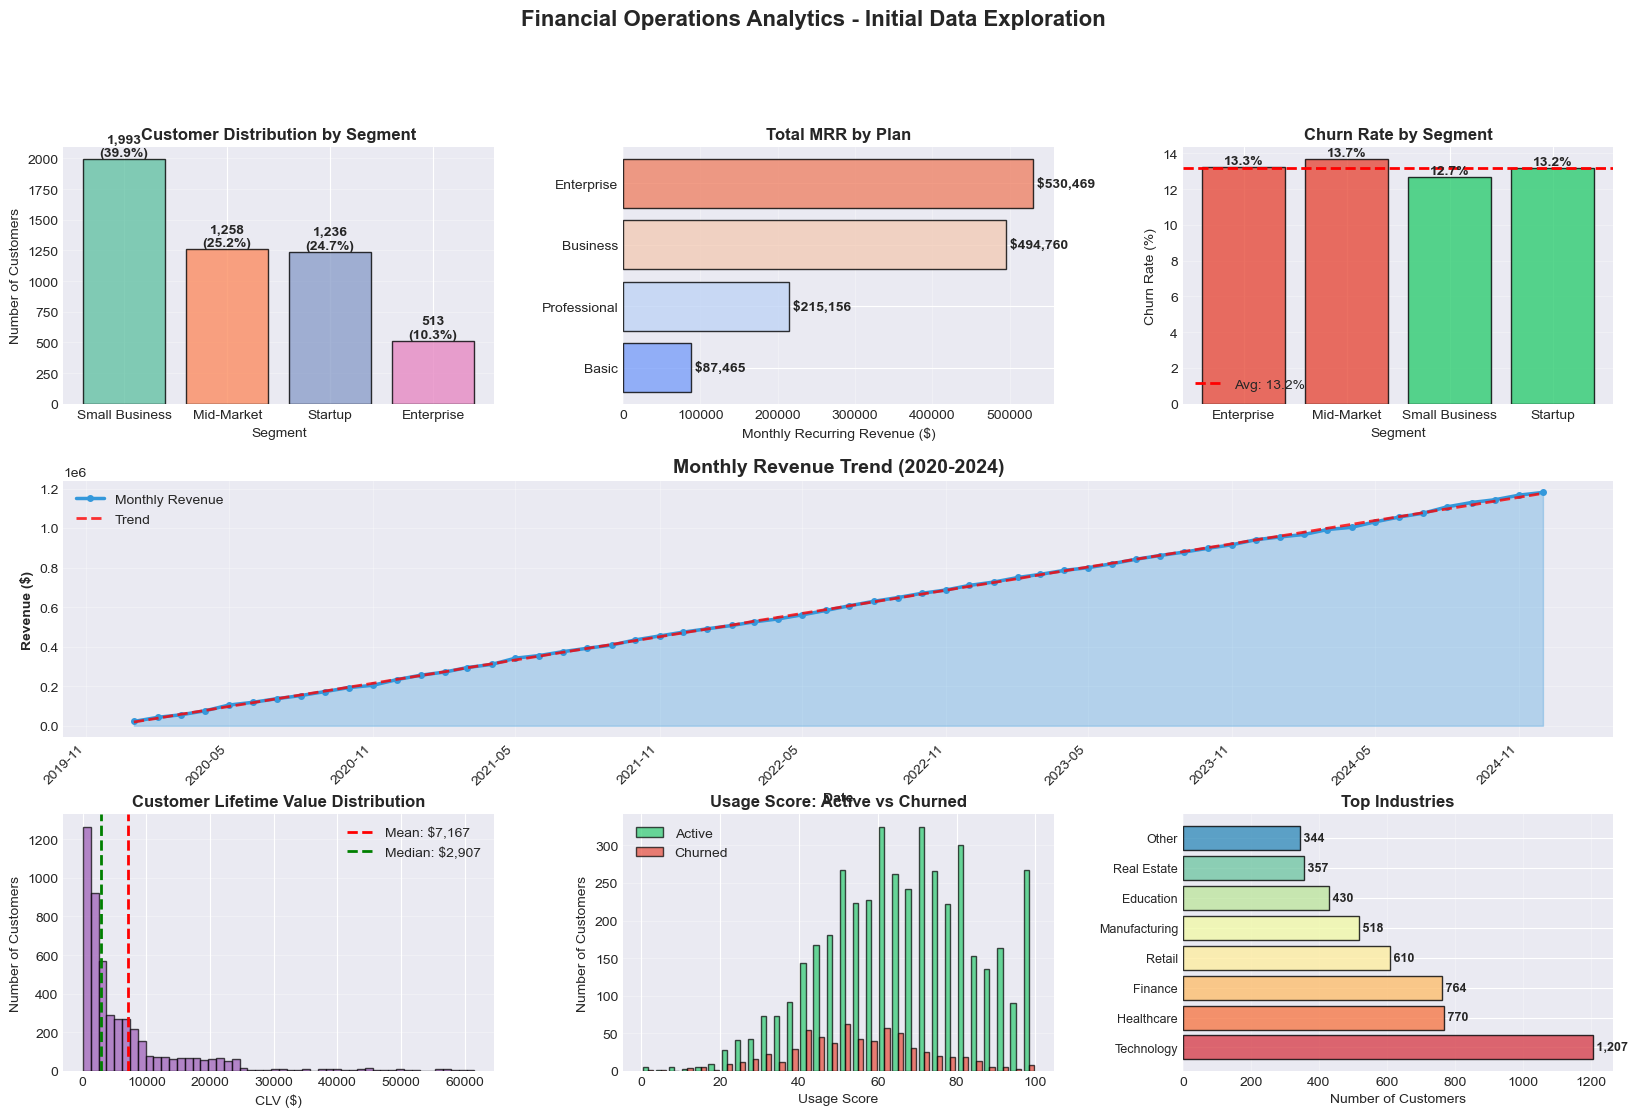


 Data exploration complete!



In [3]:
# ============================================================================
# SECTION 2: DATA UNDERSTANDING & EXPLORATION
# ============================================================================

print("="*80)
print("SECTION 2: DATA UNDERSTANDING & EXPLORATORY ANALYSIS")
print("="*80)

print("\n DEFINING BUSINESS QUESTIONS")
print("-"*80)

business_questions = """
Our analysis will answer these critical business questions:

REVENUE FORECASTING
Q1: What is our expected revenue for the next 12 months?
Q2: Are there seasonal patterns in our revenue?
Q3: What factors drive revenue growth?
Q4: What is our revenue growth rate and trend?

CHURN ANALYSIS
Q5: Which customers are most likely to churn in the next 3 months?
Q6: What are the key indicators of churn?
Q7: What is the financial impact of churn on our business?
Q8: How does churn vary by customer segment?

PROFITABILITY & COHORTS
Q9: Which customer cohorts are most valuable?
Q10: What is our customer retention rate by cohort?
Q11: How does customer lifetime value vary by segment?
Q12: What is our payback period for customer acquisition?

CUSTOMER SEGMENTATION
Q13: Can we identify distinct customer groups for targeted strategies?
Q14: Which segments are most profitable?
Q15: How should we allocate resources across segments?
"""

print(business_questions)

# ========================================================================
# 2.1: CUSTOMER DATA EXPLORATION
# ========================================================================

print("\n" + "-"*80)
print("2.1: CUSTOMER DATA EXPLORATION")
print("-"*80)

print("\n Customer Dataset Overview:")
print(f"Shape: {customers.shape[0]:,} rows × {customers.shape[1]} columns\n")

print("First 5 records:")
print(customers.head())

print("\n\nData Types:")
print(customers.dtypes)

print("\n\nSummary Statistics:")
print(customers.describe())

print("\n\nMissing Values:")
missing_summary = pd.DataFrame({
    'Column': customers.columns,
    'Missing_Count': customers.isnull().sum(),
    'Missing_Percentage': (customers.isnull().sum() / len(customers) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]
if len(missing_summary) > 0:
    print(missing_summary.to_string(index=False))
else:
    print(" No missing values detected!")

# ========================================================================
# 2.2: TRANSACTION DATA EXPLORATION
# ========================================================================

print("\n\n" + "-"*80)
print("2.2: TRANSACTION DATA EXPLORATION")
print("-"*80)

print("\n Transaction Dataset Overview:")
print(f"Shape: {transactions.shape[0]:,} rows × {transactions.shape[1]} columns\n")

print("First 5 records:")
print(transactions.head())

print("\n\nTransaction Statistics:")
print(f"Total Revenue: ${transactions['amount'].sum():,.2f}")
print(f"Average Transaction: ${transactions['amount'].mean():.2f}")
print(f"Median Transaction: ${transactions['amount'].median():.2f}")
print(f"Std Dev: ${transactions['amount'].std():.2f}")
print(f"Min Transaction: ${transactions['amount'].min():.2f}")
print(f"Max Transaction: ${transactions['amount'].max():.2f}")

print("\n\nTransaction Types:")
print(transactions['transaction_type'].value_counts())

print("\n\nPayment Methods:")
print(transactions['payment_method'].value_counts())

# ========================================================================
# 2.3: REVENUE DATA EXPLORATION
# ========================================================================

print("\n\n" + "-"*80)
print("2.3: MONTHLY REVENUE EXPLORATION")
print("-"*80)

print("\n📊 Monthly Revenue Dataset Overview:")
print(f"Shape: {monthly_revenue.shape[0]:,} rows × {monthly_revenue.shape[1]} columns\n")

print("First 10 periods:")
print(monthly_revenue.head(10))

print("\n\nRevenue Trend Statistics:")
print(f"Total Revenue (All Time): ${monthly_revenue['total_revenue'].sum():,.2f}")
print(f"Average Monthly Revenue: ${monthly_revenue['total_revenue'].mean():,.2f}")
print(f"Highest Month: ${monthly_revenue['total_revenue'].max():,.2f}")
print(f"Lowest Month: ${monthly_revenue['total_revenue'].min():,.2f}")
print(f"Average Growth Rate: {monthly_revenue['revenue_growth'].mean():.2f}%")

# ========================================================================
# 2.4: INITIAL VISUALIZATIONS
# ========================================================================

print("\n\n" + "-"*80)
print("2.4: INITIAL DATA VISUALIZATIONS")
print("-"*80)

# Create comprehensive initial exploration visualizations
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Customer Segment Distribution
ax1 = fig.add_subplot(gs[0, 0])
segment_counts = customers['segment'].value_counts()
colors1 = sns.color_palette("Set2", len(segment_counts))
ax1.bar(segment_counts.index, segment_counts.values, color=colors1, alpha=0.8, edgecolor='black')
ax1.set_title('Customer Distribution by Segment', fontweight='bold', fontsize=12)
ax1.set_ylabel('Number of Customers')
ax1.set_xlabel('Segment')
for i, v in enumerate(segment_counts.values):
    ax1.text(i, v, f'{v:,}\n({v/len(customers)*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Monthly Recurring Revenue by Plan
ax2 = fig.add_subplot(gs[0, 1])
plan_revenue = customers.groupby('plan')['mrr'].sum().sort_values(ascending=True)
colors2 = sns.color_palette("coolwarm", len(plan_revenue))
ax2.barh(plan_revenue.index, plan_revenue.values, color=colors2, alpha=0.8, edgecolor='black')
ax2.set_title('Total MRR by Plan', fontweight='bold', fontsize=12)
ax2.set_xlabel('Monthly Recurring Revenue ($)')
for i, v in enumerate(plan_revenue.values):
    ax2.text(v, i, f' ${v:,.0f}', va='center', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Churn Rate by Segment
ax3 = fig.add_subplot(gs[0, 2])
churn_by_segment = customers.groupby('segment')['is_churned'].mean() * 100
colors3 = ['#e74c3c' if x > churn_by_segment.mean() else '#2ecc71' for x in churn_by_segment.values]
ax3.bar(churn_by_segment.index, churn_by_segment.values, color=colors3, alpha=0.8, edgecolor='black')
ax3.set_title('Churn Rate by Segment', fontweight='bold', fontsize=12)
ax3.set_ylabel('Churn Rate (%)')
ax3.set_xlabel('Segment')
ax3.axhline(y=churn_by_segment.mean(), color='red', linestyle='--', 
            label=f'Avg: {churn_by_segment.mean():.1f}%', linewidth=2)
for i, v in enumerate(churn_by_segment.values):
    ax3.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Revenue Trend Over Time
ax4 = fig.add_subplot(gs[1, :])
ax4.plot(monthly_revenue['year_month'], monthly_revenue['total_revenue'], 
         linewidth=2.5, color='#3498db', marker='o', markersize=4, label='Monthly Revenue')
ax4.fill_between(monthly_revenue['year_month'], monthly_revenue['total_revenue'], 
                  alpha=0.3, color='#3498db')
ax4.set_title('Monthly Revenue Trend (2020-2024)', fontweight='bold', fontsize=14)
ax4.set_xlabel('Date', fontweight='bold')
ax4.set_ylabel('Revenue ($)', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Add trend line
z = np.polyfit(range(len(monthly_revenue)), monthly_revenue['total_revenue'], 1)
p = np.poly1d(z)
ax4.plot(monthly_revenue['year_month'], p(range(len(monthly_revenue))), 
         "r--", alpha=0.8, linewidth=2, label='Trend')
ax4.legend()

# Format x-axis
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 5. Customer Lifetime Value Distribution
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(customers['clv'], bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
ax5.axvline(customers['clv'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: ${customers["clv"].mean():,.0f}')
ax5.axvline(customers['clv'].median(), color='green', linestyle='--', 
            linewidth=2, label=f'Median: ${customers["clv"].median():,.0f}')
ax5.set_title('Customer Lifetime Value Distribution', fontweight='bold', fontsize=12)
ax5.set_xlabel('CLV ($)')
ax5.set_ylabel('Number of Customers')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Usage Score vs Churn
ax6 = fig.add_subplot(gs[2, 1])
churned = customers[customers['is_churned'] == 1]['usage_score']
active = customers[customers['is_churned'] == 0]['usage_score']
ax6.hist([active, churned], bins=30, label=['Active', 'Churned'], 
         color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax6.set_title('Usage Score: Active vs Churned', fontweight='bold', fontsize=12)
ax6.set_xlabel('Usage Score')
ax6.set_ylabel('Number of Customers')
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

# 7. Industry Distribution
ax7 = fig.add_subplot(gs[2, 2])
industry_counts = customers['industry'].value_counts().head(8)
colors7 = sns.color_palette("Spectral", len(industry_counts))
ax7.barh(range(len(industry_counts)), industry_counts.values, color=colors7, alpha=0.8, edgecolor='black')
ax7.set_yticks(range(len(industry_counts)))
ax7.set_yticklabels(industry_counts.index, fontsize=9)
ax7.set_title('Top Industries', fontweight='bold', fontsize=12)
ax7.set_xlabel('Number of Customers')
for i, v in enumerate(industry_counts.values):
    ax7.text(v, i, f' {v:,}', va='center', fontweight='bold', fontsize=9)
ax7.grid(axis='x', alpha=0.3)

plt.suptitle('Financial Operations Analytics - Initial Data Exploration', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('financial_viz/01_initial_exploration.png', dpi=300, bbox_inches='tight')
print(" Saved: financial_viz/01_initial_exploration.png")
plt.show()

print("\n Data exploration complete!\n")


SECTION 3: REVENUE FORECASTING - TIME SERIES ANALYSIS

Time series forecasting helps us:
1. Predict future revenue with confidence intervals
2. Identify seasonal patterns and trends
3. Support strategic planning and budgeting
4. Set realistic targets and goals

We'll use multiple techniques:
- Statistical decomposition
- ARIMA/SARIMA models
- Facebook Prophet (if available) # Try it when you will follow the steps
- Exponential smoothing


--------------------------------------------------------------------------------
3.1: TIME SERIES DATA PREPARATION
--------------------------------------------------------------------------------

 Time Series Overview:
   • Start Date: 2020-01-01 00:00:00
   • End Date: 2024-12-01 00:00:00
   • Number of Periods: 60
   • Frequency: Monthly
   No missing periods

--------------------------------------------------------------------------------
3.2: TIME SERIES DECOMPOSITION
------------------------------------------------------------------------------

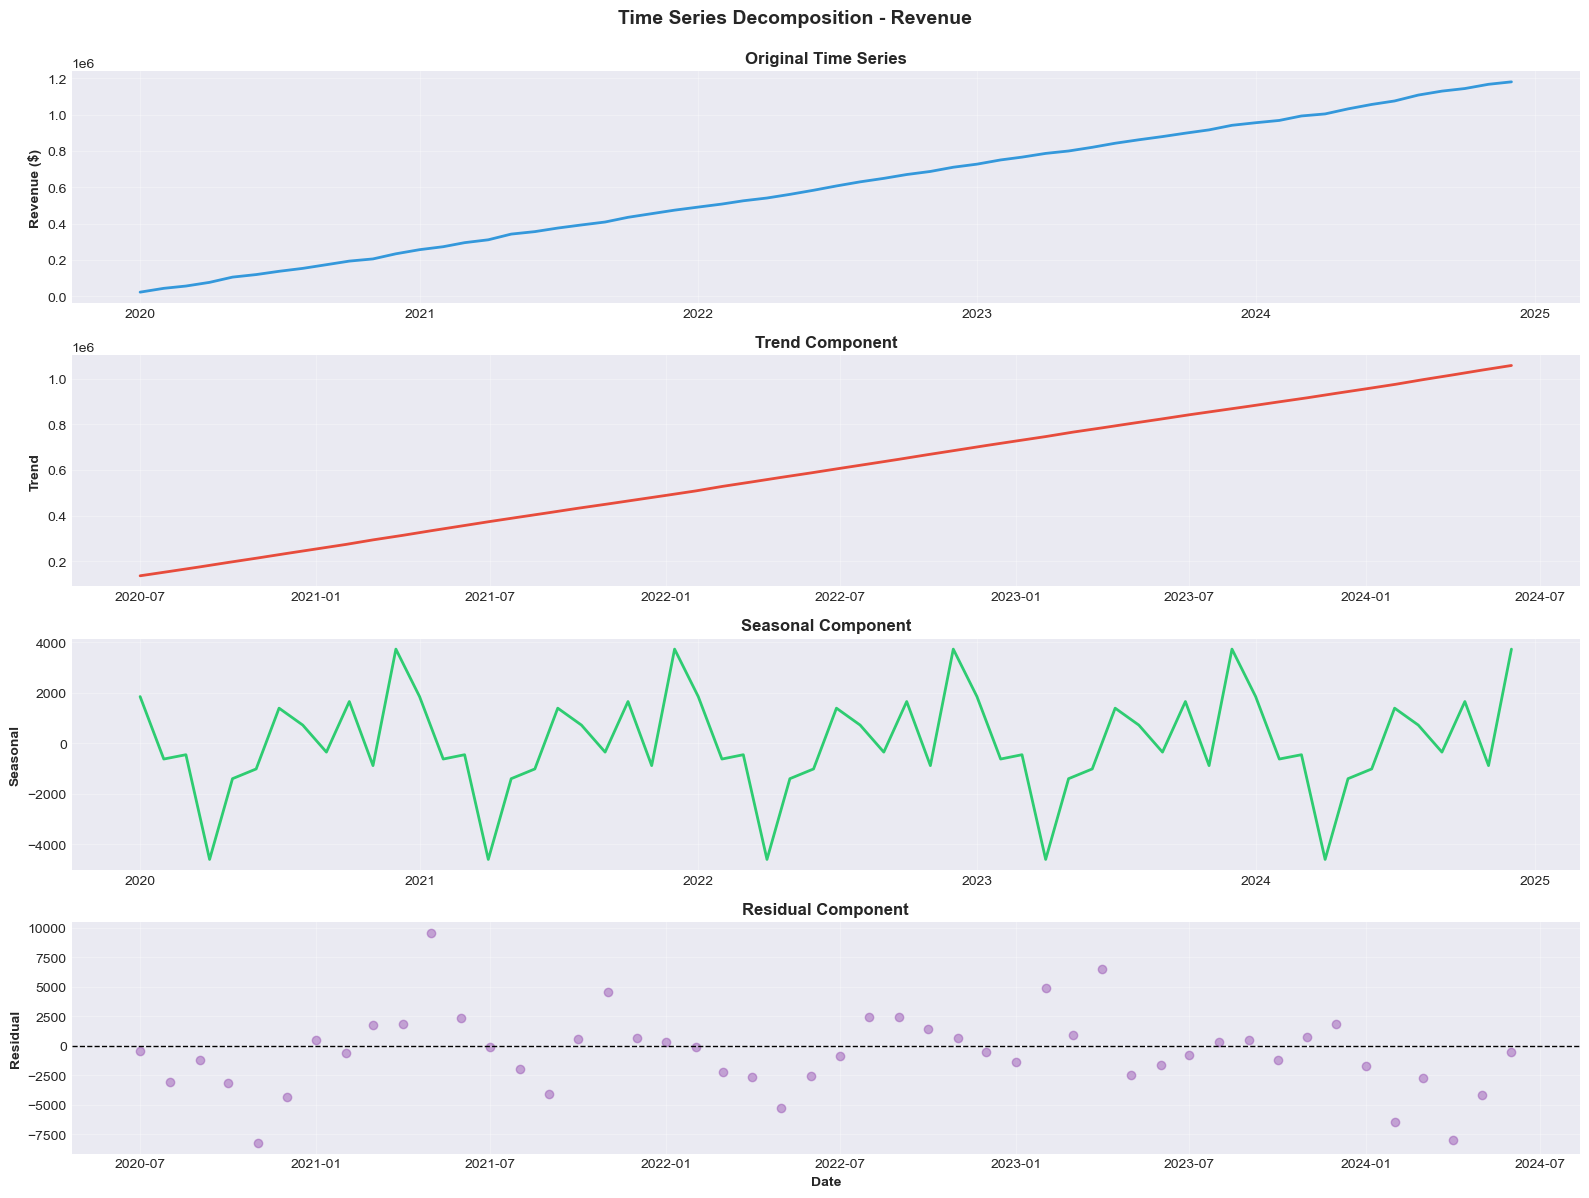


📊 Decomposition Analysis:
   • Seasonal Strength: 0.271 (0=none, 1=perfect)
   • Trend Strength: 1.000
   Weak seasonality - ARIMA may suffice

--------------------------------------------------------------------------------
3.3: STATIONARITY TESTING (Augmented Dickey-Fuller Test)
--------------------------------------------------------------------------------

Stationarity is crucial for ARIMA modeling.
A stationary series has:
  • Constant mean over time
  • Constant variance over time
  • No seasonality

ADF Test:
  • H0 (null): Series has a unit root (non-stationary)
  • H1 (alternative): Series is stationary
  • If p-value < 0.05, we reject H0 (series is stationary)


ADF Test Results:
   • ADF Statistic: 0.9980
   • P-value: 0.9942
   • Critical Values:
      - 1%: -3.5553
      - 5%: -2.9157
      - 10%: -2.5957

   Series is non-stationary (p >= 0.05)
   → Differencing required for ARIMA modeling

   After first differencing:
   • ADF Statistic: -4.7060
   • P-value: 0.0001
  

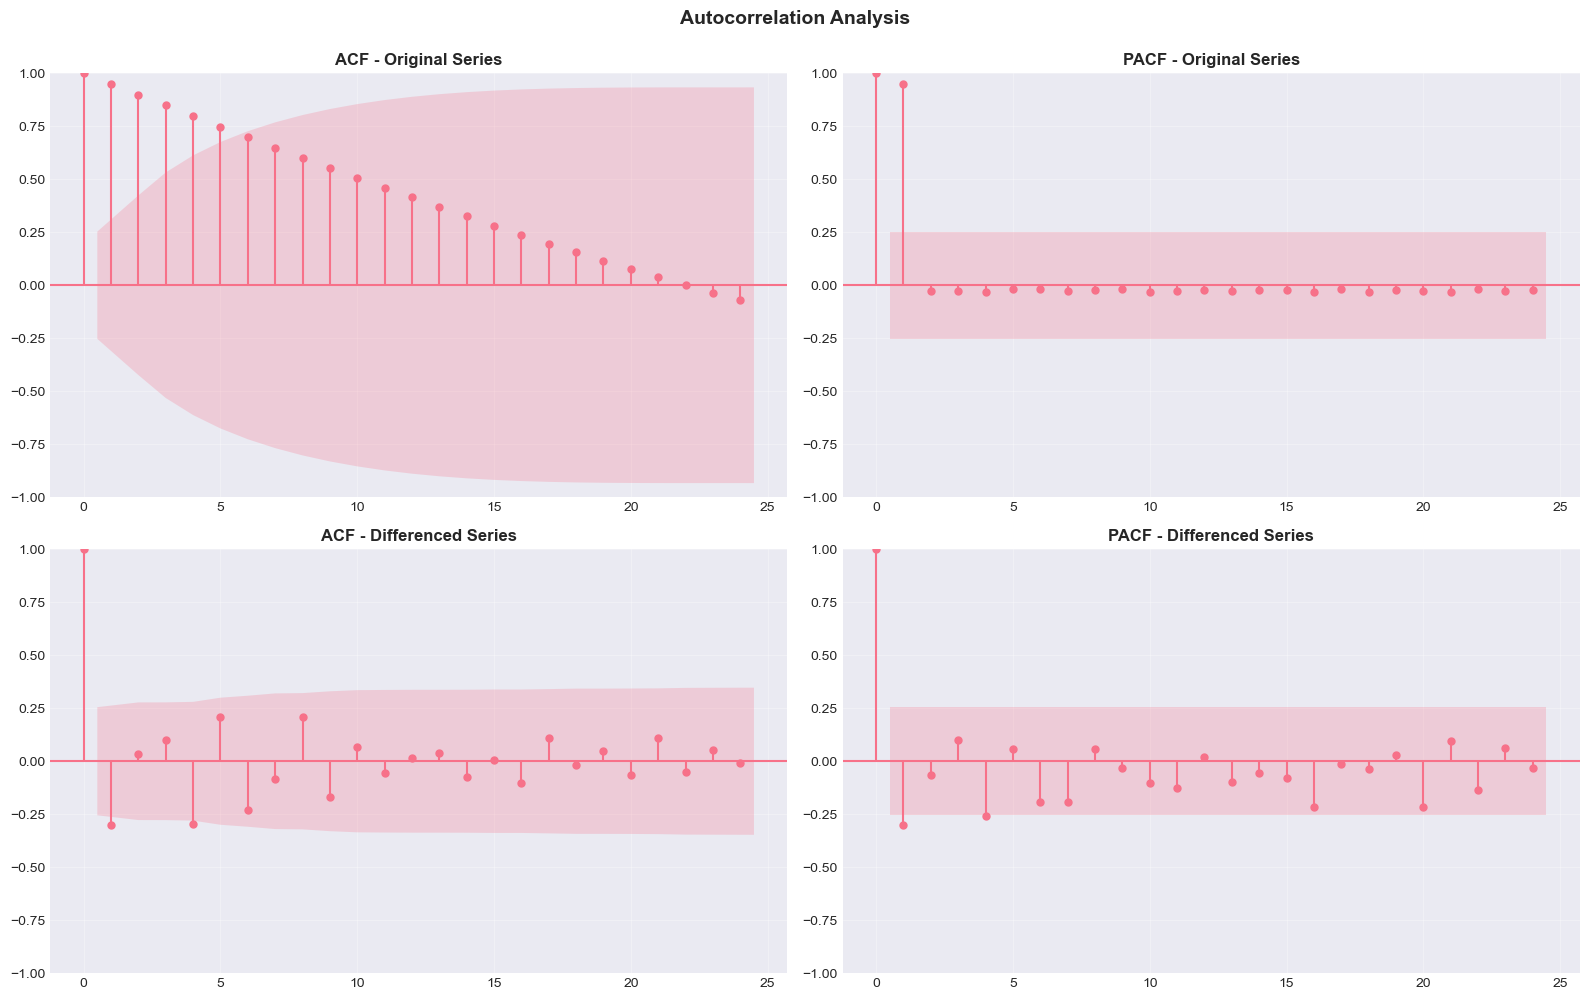


--------------------------------------------------------------------------------
3.5: ARIMA MODEL TRAINING
--------------------------------------------------------------------------------

ARIMA Model Parameters:
  • p: AR (autoregressive) order - based on PACF
  • d: Differencing order - based on stationarity test
  • q: MA (moving average) order - based on ACF

We'll test multiple parameter combinations and select the best model.


Data Split:
   • Training Set: 48 periods (2020-01-01 00:00:00 to 2023-12-01 00:00:00)
   • Test Set: 12 periods (2024-01-01 00:00:00 to 2024-12-01 00:00:00)

 Searching for optimal ARIMA parameters...
Testing combinations of p=[0,1,2], d=[0,1], q=[0,1,2]

   ARIMA(0,0,0) - AIC: 1480.10
   ARIMA(0,0,1) - AIC: 1306.00
   ARIMA(0,0,2) - AIC: 1295.17
   ARIMA(0,1,0) - AIC: 1066.29
   ARIMA(0,1,1) - AIC: 1042.10
   ARIMA(0,1,2) - AIC: 1035.13
   ARIMA(1,0,0) - AIC: 1099.16


C:\Users\DELL\Downloads\Jupyter\New folder\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   ARIMA(1,0,1) - AIC: 1064.71


C:\Users\DELL\Downloads\Jupyter\New folder\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   ARIMA(1,0,2) - AIC: 1031.73
   ARIMA(1,1,0) - AIC: 964.95
   ARIMA(1,1,1) - AIC: 926.58
   ARIMA(1,1,2) - AIC: 922.51
   ARIMA(2,0,0) - AIC: 1001.41
   ARIMA(2,0,1) - AIC: 1091.92
   ARIMA(2,0,2) - AIC: 1105.48
   ARIMA(2,1,0) - AIC: 945.41


C:\Users\DELL\Downloads\Jupyter\New folder\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   ARIMA(2,1,1) - AIC: 923.71
   ARIMA(2,1,2) - AIC: 930.37

 Best Model: ARIMA(1, 1, 2) with AIC = 922.51

--------------------------------------------------------------------------------
MODEL SUMMARY
--------------------------------------------------------------------------------
                               SARIMAX Results                                
Dep. Variable:          total_revenue   No. Observations:                   48
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -457.254
Date:                Tue, 10 Feb 2026   AIC                            922.508
Time:                        20:58:58   BIC                            929.909
Sample:                    01-01-2020   HQIC                           925.293
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

C:\Users\DELL\Downloads\Jupyter\New folder\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 12-Month Revenue Forecast:

  Month  Forecasted_Revenue  Lower_95%  Upper_95%
2025-01          1201650.27 1192729.15 1210571.39
2025-02          1221318.32 1210320.37 1232316.27
2025-03          1240986.37 1228194.31 1253778.42
2025-04          1260654.41 1246244.98 1275063.84
2025-05          1280322.46 1264418.37 1296226.54
2025-06          1299990.50 1282682.65 1317298.35
2025-07          1319658.55 1301017.29 1338299.81
2025-08          1339326.59 1319408.14 1359245.05
2025-09          1358994.64 1337845.02 1380144.26
2025-10          1378662.68 1356320.31 1401005.05
2025-11          1398330.73 1374828.18 1421833.28
2025-12          1417998.77 1393364.01 1442633.53

 Summary Statistics:
   • Total Forecasted Revenue (12 months): $15,717,894.28
   • Average Monthly Revenue: $1,309,824.52
   • Expected Growth from Last Month: $21,274.71

 Saved: financial_viz/04_arima_forecast.png


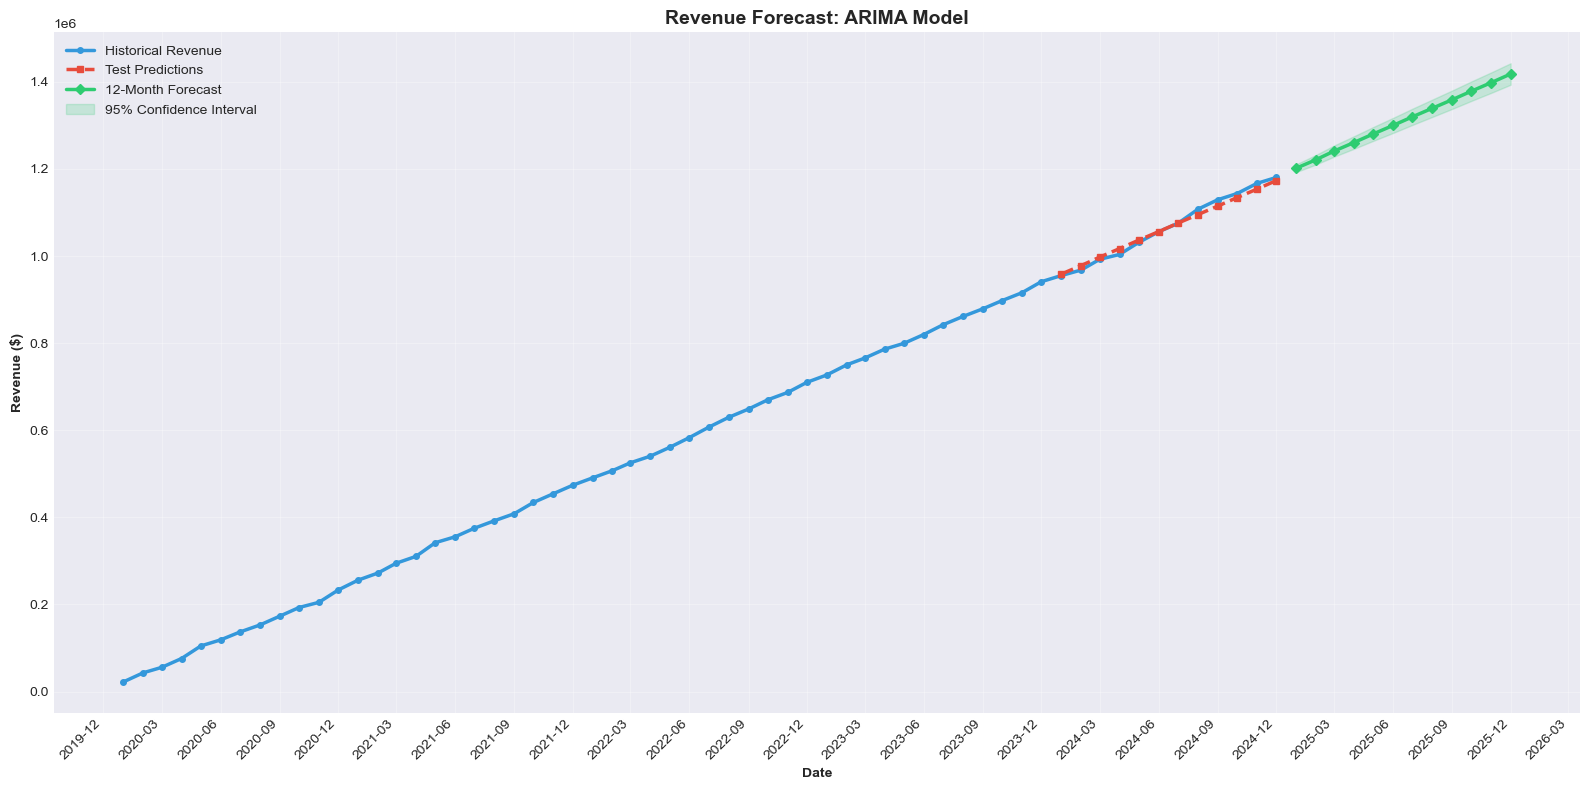


 Facebook Prophet not available. Skipping Prophet forecasting.
Install with: pip install prophet

 Revenue Forecasting Complete!



In [4]:
# ============================================================================
# SECTION 3: REVENUE FORECASTING - TIME SERIES ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 3: REVENUE FORECASTING - TIME SERIES ANALYSIS")
print("="*80)

print("""
Time series forecasting helps us:
1. Predict future revenue with confidence intervals
2. Identify seasonal patterns and trends
3. Support strategic planning and budgeting
4. Set realistic targets and goals

We'll use multiple techniques:
- Statistical decomposition
- ARIMA/SARIMA models
- Facebook Prophet (if available) # Try it when you will follow the steps
- Exponential smoothing
""")

# ========================================================================
# 3.1: TIME SERIES PREPARATION
# ========================================================================

print("\n" + "-"*80)
print("3.1: TIME SERIES DATA PREPARATION")
print("-"*80)

# Prepare time series data
ts_data = monthly_revenue[['year_month', 'total_revenue']].copy()
ts_data.set_index('year_month', inplace=True)
ts_data.index.freq = 'MS'  # Month Start frequency

print(f"\n Time Series Overview:")
print(f"   • Start Date: {ts_data.index.min()}")
print(f"   • End Date: {ts_data.index.max()}")
print(f"   • Number of Periods: {len(ts_data)}")
print(f"   • Frequency: Monthly")

# Check for missing periods
expected_periods = pd.date_range(start=ts_data.index.min(), 
                                  end=ts_data.index.max(), 
                                  freq='MS')
missing_periods = expected_periods.difference(ts_data.index)
if len(missing_periods) > 0:
    print(f"   Missing periods detected: {len(missing_periods)}")
else:
    print(f"   No missing periods")

# ========================================================================
# 3.2: TIME SERIES DECOMPOSITION
# ========================================================================

print("\n" + "-"*80)
print("3.2: TIME SERIES DECOMPOSITION")
print("-"*80)

print("\nDecomposing time series into:")
print("   • Trend: Long-term progression")
print("   • Seasonality: Repeating patterns")
print("   • Residual: Random fluctuations\n")

# Perform seasonal decomposition
decomposition = seasonal_decompose(ts_data['total_revenue'], 
                                   model='additive', 
                                   period=12)

# Create decomposition plot
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original
axes[0].plot(ts_data.index, ts_data['total_revenue'], linewidth=2, color='#3498db')
axes[0].set_ylabel('Revenue ($)', fontweight='bold')
axes[0].set_title('Original Time Series', fontweight='bold', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend, linewidth=2, color='#e74c3c')
axes[1].set_ylabel('Trend', fontweight='bold')
axes[1].set_title('Trend Component', fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Seasonality
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal, linewidth=2, color='#2ecc71')
axes[2].set_ylabel('Seasonal', fontweight='bold')
axes[2].set_title('Seasonal Component', fontweight='bold', fontsize=12)
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].scatter(decomposition.resid.index, decomposition.resid, alpha=0.5, color='#9b59b6')
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[3].set_ylabel('Residual', fontweight='bold')
axes[3].set_xlabel('Date', fontweight='bold')
axes[3].set_title('Residual Component', fontweight='bold', fontsize=12)
axes[3].grid(True, alpha=0.3)

plt.suptitle('Time Series Decomposition - Revenue', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('financial_viz/02_ts_decomposition.png', dpi=300, bbox_inches='tight')
print(" Saved: financial_viz/02_ts_decomposition.png")
plt.show()

# Calculate seasonality strength
seasonal_strength = 1 - (decomposition.resid.var() / (decomposition.seasonal + decomposition.resid).var())
trend_strength = 1 - (decomposition.resid.var() / (decomposition.trend + decomposition.resid).var())

print(f"\n📊 Decomposition Analysis:")
print(f"   • Seasonal Strength: {seasonal_strength:.3f} (0=none, 1=perfect)")
print(f"   • Trend Strength: {trend_strength:.3f}")
if seasonal_strength > 0.6:
    print(f"   Strong seasonality detected - use SARIMA")
else:
    print(f"   Weak seasonality - ARIMA may suffice")

# ========================================================================
# 3.3: STATIONARITY TEST
# ========================================================================

print("\n" + "-"*80)
print("3.3: STATIONARITY TESTING (Augmented Dickey-Fuller Test)")
print("-"*80)

print("""
Stationarity is crucial for ARIMA modeling.
A stationary series has:
  • Constant mean over time
  • Constant variance over time
  • No seasonality

ADF Test:
  • H0 (null): Series has a unit root (non-stationary)
  • H1 (alternative): Series is stationary
  • If p-value < 0.05, we reject H0 (series is stationary)
""")

# Perform ADF test
adf_result = adfuller(ts_data['total_revenue'].dropna())

print(f"\nADF Test Results:")
print(f"   • ADF Statistic: {adf_result[0]:.4f}")
print(f"   • P-value: {adf_result[1]:.4f}")
print(f"   • Critical Values:")
for key, value in adf_result[4].items():
    print(f"      - {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print(f"\n   Series is stationary (p < 0.05)")
    differencing_needed = False
else:
    print(f"\n   Series is non-stationary (p >= 0.05)")
    print(f"   → Differencing required for ARIMA modeling")
    differencing_needed = True

# If non-stationary, apply differencing
if differencing_needed:
    ts_data['revenue_diff'] = ts_data['total_revenue'].diff()
    
    # Test differenced series
    adf_diff = adfuller(ts_data['revenue_diff'].dropna())
    print(f"\n   After first differencing:")
    print(f"   • ADF Statistic: {adf_diff[0]:.4f}")
    print(f"   • P-value: {adf_diff[1]:.4f}")
    
    if adf_diff[1] < 0.05:
        print(f"   Differenced series is stationary")

# ========================================================================
# 3.4: ACF AND PACF ANALYSIS
# ========================================================================

print("\n" + "-"*80)
print("3.4: ACF & PACF ANALYSIS (For ARIMA Parameter Selection)")
print("-"*80)

print("""
ACF (Autocorrelation Function):
  • Shows correlation between time series and its lagged values
  • Helps determine MA (Moving Average) order (q)

PACF (Partial Autocorrelation Function):
  • Shows correlation between observations at different lags
  • Helps determine AR (Autoregressive) order (p)
""")

# Create ACF and PACF plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF - Original
plot_acf(ts_data['total_revenue'].dropna(), lags=24, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Original Series', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# PACF - Original
plot_pacf(ts_data['total_revenue'].dropna(), lags=24, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Original Series', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# ACF - Differenced (if needed)
if differencing_needed:
    plot_acf(ts_data['revenue_diff'].dropna(), lags=24, ax=axes[1, 0])
    axes[1, 0].set_title('ACF - Differenced Series', fontweight='bold', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    
    plot_pacf(ts_data['revenue_diff'].dropna(), lags=24, ax=axes[1, 1])
    axes[1, 1].set_title('PACF - Differenced Series', fontweight='bold', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3)
else:
    # If stationary, show seasonal patterns
    axes[1, 0].plot(range(1, 13), [ts_data[ts_data.index.month == m]['total_revenue'].mean() 
                                    for m in range(1, 13)], 
                   marker='o', linewidth=2, markersize=8, color='#e74c3c')
    axes[1, 0].set_title('Average Revenue by Month', fontweight='bold', fontsize=12)
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Average Revenue ($)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xticks(range(1, 13))
    
    axes[1, 1].boxplot([ts_data[ts_data.index.month == m]['total_revenue'] 
                        for m in range(1, 13)])
    axes[1, 1].set_title('Revenue Distribution by Month', fontweight='bold', fontsize=12)
    axes[1, 1].set_xlabel('Month')
    axes[1, 1].set_ylabel('Revenue ($)')
    axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Autocorrelation Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('financial_viz/03_acf_pacf_analysis.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/03_acf_pacf_analysis.png")
plt.show()

# ========================================================================
# 3.5: ARIMA MODEL TRAINING
# ========================================================================

print("\n" + "-"*80)
print("3.5: ARIMA MODEL TRAINING")
print("-"*80)

print("""
ARIMA Model Parameters:
  • p: AR (autoregressive) order - based on PACF
  • d: Differencing order - based on stationarity test
  • q: MA (moving average) order - based on ACF

We'll test multiple parameter combinations and select the best model.
""")

# Split data: train on first 80%, test on last 20%
train_size = int(len(ts_data) * 0.8)
train_data = ts_data['total_revenue'][:train_size]
test_data = ts_data['total_revenue'][train_size:]

print(f"\nData Split:")
print(f"   • Training Set: {len(train_data)} periods ({train_data.index.min()} to {train_data.index.max()})")
print(f"   • Test Set: {len(test_data)} periods ({test_data.index.min()} to {test_data.index.max()})")

# Grid search for best ARIMA parameters
print("\n Searching for optimal ARIMA parameters...")
print("Testing combinations of p=[0,1,2], d=[0,1], q=[0,1,2]\n")

best_aic = np.inf
best_params = None
best_model = None

results_list = []

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = ARIMA(train_data, order=(p, d, q))
                fitted_model = model.fit()
                aic = fitted_model.aic
                results_list.append({'p': p, 'd': d, 'q': q, 'AIC': aic})
                
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, d, q)
                    best_model = fitted_model
                    
                print(f"   ARIMA({p},{d},{q}) - AIC: {aic:.2f}")
            except Exception as e:
                print(f"   ARIMA({p},{d},{q}) - Failed: {str(e)[:50]}")
                continue

print(f"\n Best Model: ARIMA{best_params} with AIC = {best_aic:.2f}")

# Display model summary
print("\n" + "-"*80)
print("MODEL SUMMARY")
print("-"*80)
print(best_model.summary())

# Make predictions on test set
predictions = best_model.forecast(steps=len(test_data))

# Calculate error metrics
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

print("\n" + "-"*80)
print("MODEL PERFORMANCE ON TEST SET")
print("-"*80)
print(f"   • MAE (Mean Absolute Error): ${mae:,.2f}")
print(f"   • RMSE (Root Mean Squared Error): ${rmse:,.2f}")
print(f"   • MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

# ========================================================================
# 3.6: FUTURE FORECASTING
# ========================================================================

print("\n" + "-"*80)
print("3.6: REVENUE FORECASTING - NEXT 12 MONTHS")
print("-"*80)

# Refit model on full dataset
final_model = ARIMA(ts_data['total_revenue'], order=best_params)
final_fitted = final_model.fit()

# Forecast next 12 months
forecast_periods = 12
forecast = final_fitted.forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=ts_data.index.max() + pd.DateOffset(months=1), 
                                periods=forecast_periods, 
                                freq='MS')

# Get confidence intervals
forecast_df = final_fitted.get_forecast(steps=forecast_periods)
forecast_ci = forecast_df.conf_int()

print(f"\n 12-Month Revenue Forecast:\n")
forecast_summary = pd.DataFrame({
    'Month': forecast_index.strftime('%Y-%m'),
    'Forecasted_Revenue': forecast.values,
    'Lower_95%': forecast_ci.iloc[:, 0].values,
    'Upper_95%': forecast_ci.iloc[:, 1].values
})
print(forecast_summary.to_string(index=False))

print(f"\n Summary Statistics:")
print(f"   • Total Forecasted Revenue (12 months): ${forecast.sum():,.2f}")
print(f"   • Average Monthly Revenue: ${forecast.mean():,.2f}")
print(f"   • Expected Growth from Last Month: ${(forecast.iloc[0] - ts_data['total_revenue'].iloc[-1]):,.2f}")

# Visualize forecast
fig, ax = plt.subplots(figsize=(16, 8))

# Historical data
ax.plot(ts_data.index, ts_data['total_revenue'], 
        linewidth=2.5, color='#3498db', label='Historical Revenue', marker='o', markersize=4)

# Test set predictions (if we want to show validation)
ax.plot(test_data.index, predictions, 
        linewidth=2.5, color='#e74c3c', label='Test Predictions', 
        marker='s', markersize=4, linestyle='--')

# Future forecast
ax.plot(forecast_index, forecast, 
        linewidth=2.5, color='#2ecc71', label='12-Month Forecast', 
        marker='D', markersize=5)

# Confidence interval
ax.fill_between(forecast_index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color='#2ecc71', alpha=0.2, label='95% Confidence Interval')

ax.set_title('Revenue Forecast: ARIMA Model', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Revenue ($)', fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('financial_viz/04_arima_forecast.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/04_arima_forecast.png")
plt.show()

# ========================================================================
# 3.7: PROPHET MODEL (if available)
# ========================================================================

if PROPHET_AVAILABLE:
    print("\n" + "-"*80)
    print("3.7: FACEBOOK PROPHET FORECASTING")
    print("-"*80)
    
    print("""
Prophet is particularly good at:
  • Handling missing data and outliers
  • Detecting multiple seasonalities
  • Including holidays and special events
  • Providing interpretable components
    """)
    
    # Prepare data for Prophet (requires 'ds' and 'y' columns)
    prophet_df = pd.DataFrame({
        'ds': ts_data.index,
        'y': ts_data['total_revenue'].values
    })
    
    # Train Prophet model
    print("\n Training Prophet model...")
    prophet_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05
    )
    
    prophet_model.fit(prophet_df)
    print(" Prophet model trained successfully!")
    
    # Make future dataframe
    future = prophet_model.make_future_dataframe(periods=12, freq='MS')
    
    # Predict
    prophet_forecast = prophet_model.predict(future)
    
    # Extract last 12 months forecast
    prophet_future = prophet_forecast.tail(12)
    
    print(f"\n Prophet 12-Month Forecast:\n")
    prophet_summary = pd.DataFrame({
        'Month': prophet_future['ds'].dt.strftime('%Y-%m'),
        'Forecasted_Revenue': prophet_future['yhat'].values,
        'Lower_95%': prophet_future['yhat_lower'].values,
        'Upper_95%': prophet_future['yhat_upper'].values
    })
    print(prophet_summary.to_string(index=False))
    
    # Plot Prophet forecast
    fig = prophet_model.plot(prophet_forecast, figsize=(16, 8))
    ax = fig.gca()
    ax.set_title('Revenue Forecast: Facebook Prophet Model', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontweight='bold')
    ax.set_ylabel('Revenue ($)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('financial_viz/05_prophet_forecast.png', dpi=300, bbox_inches='tight')
    print("\n Saved: financial_viz/05_prophet_forecast.png")
    plt.show()
    
    # Plot components
    fig = prophet_model.plot_components(prophet_forecast, figsize=(16, 12))
    plt.suptitle('Prophet Model Components', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('financial_viz/06_prophet_components.png', dpi=300, bbox_inches='tight')
    print(" Saved: financial_viz/06_prophet_components.png")
    plt.show()
    
else:
    print("\n Facebook Prophet not available. Skipping Prophet forecasting.")
    print("Install with: pip install prophet")

print("\n Revenue Forecasting Complete!")
print("="*80 + "\n")


SECTION 4: CUSTOMER CHURN ANALYSIS & PREDICTION

Churn analysis helps us:
1. Identify customers at risk of leaving
2. Understand key churn drivers
3. Calculate financial impact of churn
4. Develop retention strategies

We'll analyze:
  • Churn rates by segment and cohort
  • Predictive models for churn risk
  • Customer lifetime value impact
  • Intervention opportunities


--------------------------------------------------------------------------------
4.1: CHURN OVERVIEW & STATISTICS
--------------------------------------------------------------------------------

 Overall Churn Metrics:
   • Total Customers: 5,000
   • Active Customers: 4,344.0 (86.9%)
   • Churned Customers: 656.0 (13.1%)

 Churn Rate by Customer Segment:
                Churned_Count  Churn_Rate  Total_Customers
segment                                                   
Mid-Market             172.00       13.67             1258
Enterprise              68.00       13.26              513
Startup                163.

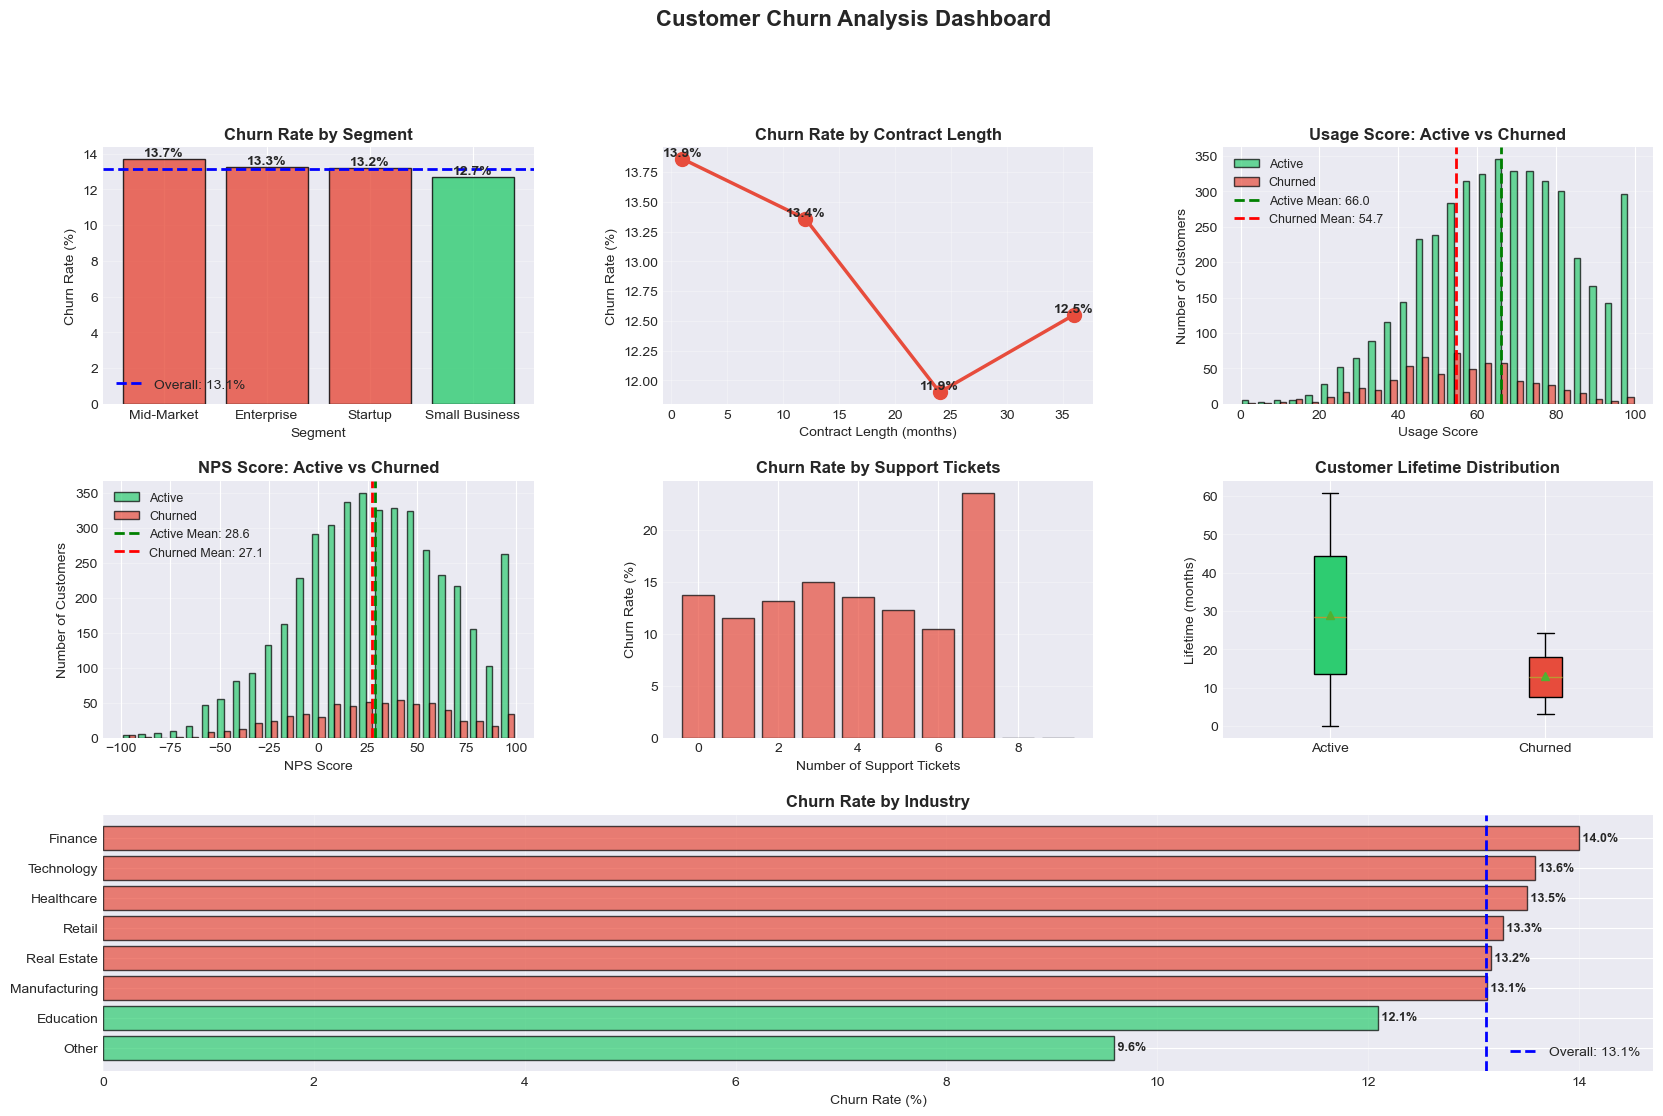


--------------------------------------------------------------------------------
4.3: FEATURE ENGINEERING FOR CHURN PREDICTION
--------------------------------------------------------------------------------

Creating predictive features...
 Created engagement and risk features

 Feature Set:
   • Numeric Features: 15
   • Categorical Features: 4
   • Total Features: 19

 Dataset for Modeling:
   • Total Samples: 5,000
   • Features: 19
   • Churned (Class 1): 656.0 (13.1%)
   • Active (Class 0): 4,344.0 (86.9%)

--------------------------------------------------------------------------------
4.4: CHURN PREDICTION MODEL TRAINING
--------------------------------------------------------------------------------

Data Split:
   • Training Set: 4,000 samples
   • Test Set: 1,000 samples

 Training Multiple Models...

 Logistic Regression...
   Accuracy: 0.9980
   ROC AUC: 0.9947

 Random Forest Classifier...
   Accuracy: 1.0000
   ROC AUC: 1.0000

 Gradient Boosting Classifier...
   Accura

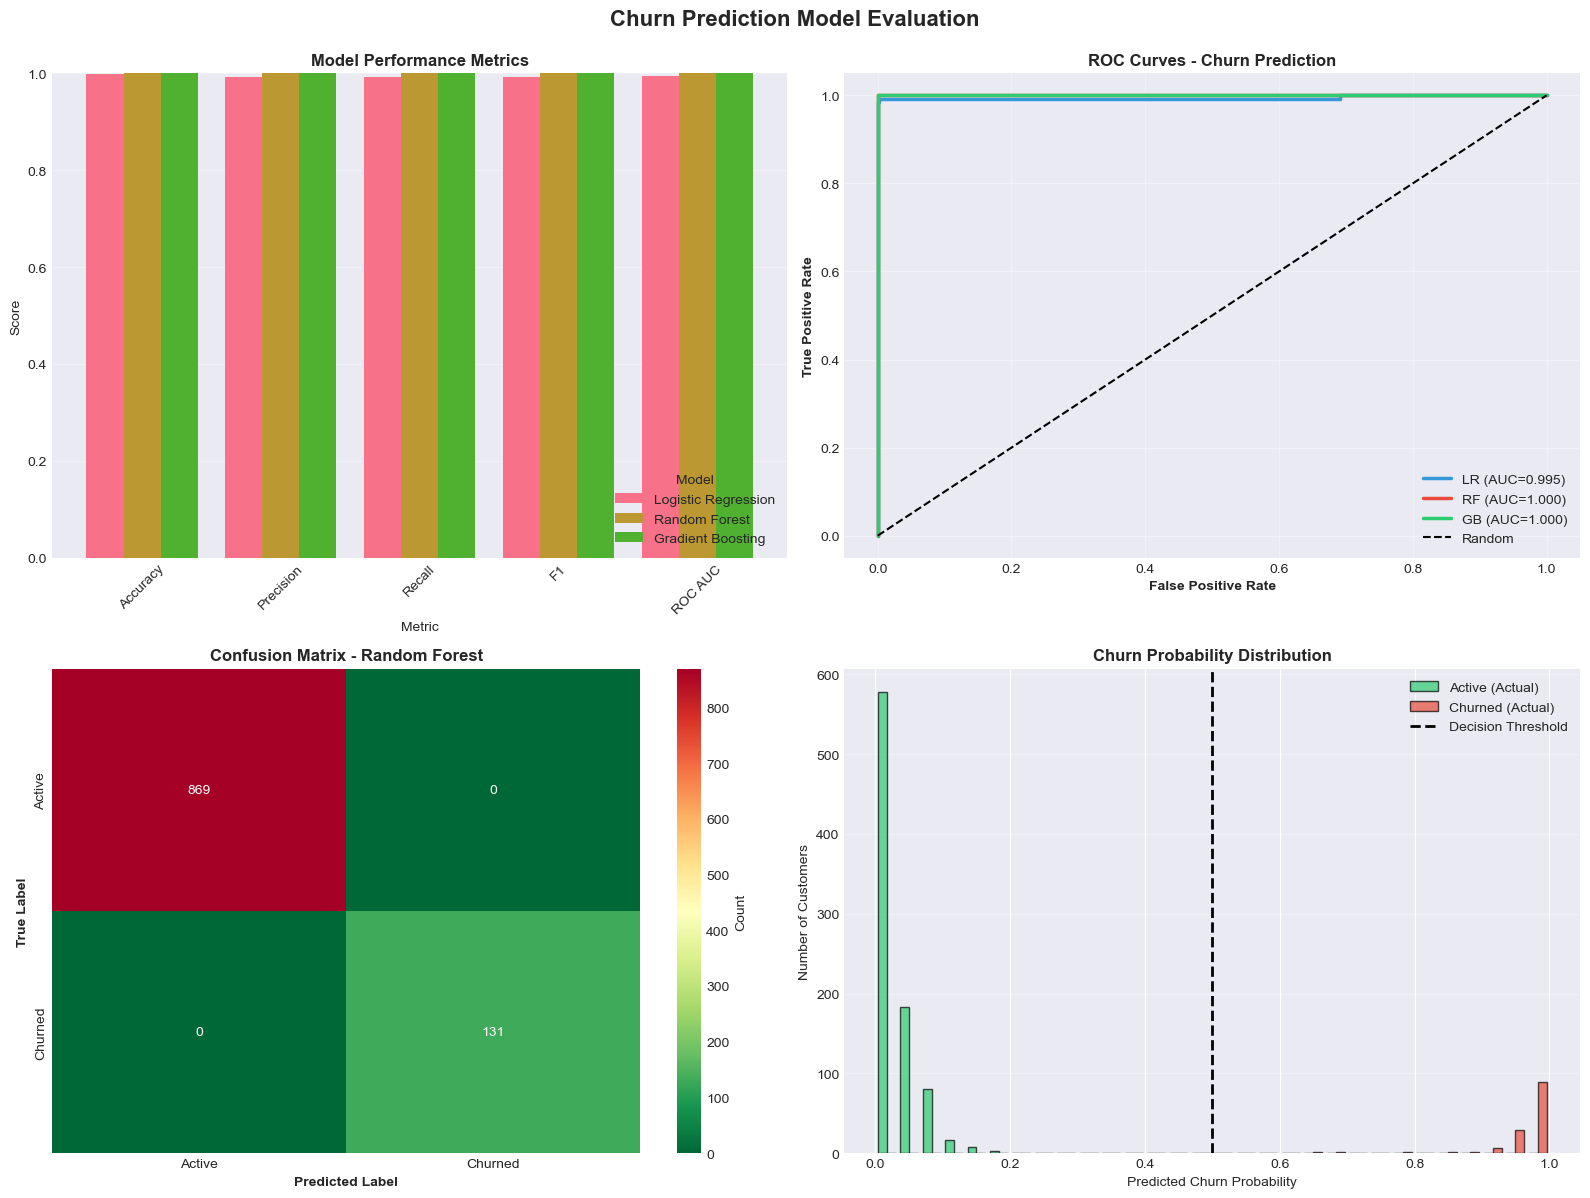


--------------------------------------------------------------------------------
4.6: FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------

 Top 15 Most Important Features for Churn Prediction:

              feature  importance
         recency_days        0.51
      lifetime_months        0.17
    transaction_count        0.13
    customer_age_days        0.12
    tickets_per_month        0.03
          usage_score        0.02
avg_transaction_value        0.00
      support_tickets        0.00
      number_of_users        0.00
            nps_score        0.00
            low_usage        0.00
      country_encoded        0.00
     industry_encoded        0.00
      contract_length        0.00
         plan_encoded        0.00

 Saved: financial_viz/09_churn_feature_importance.png


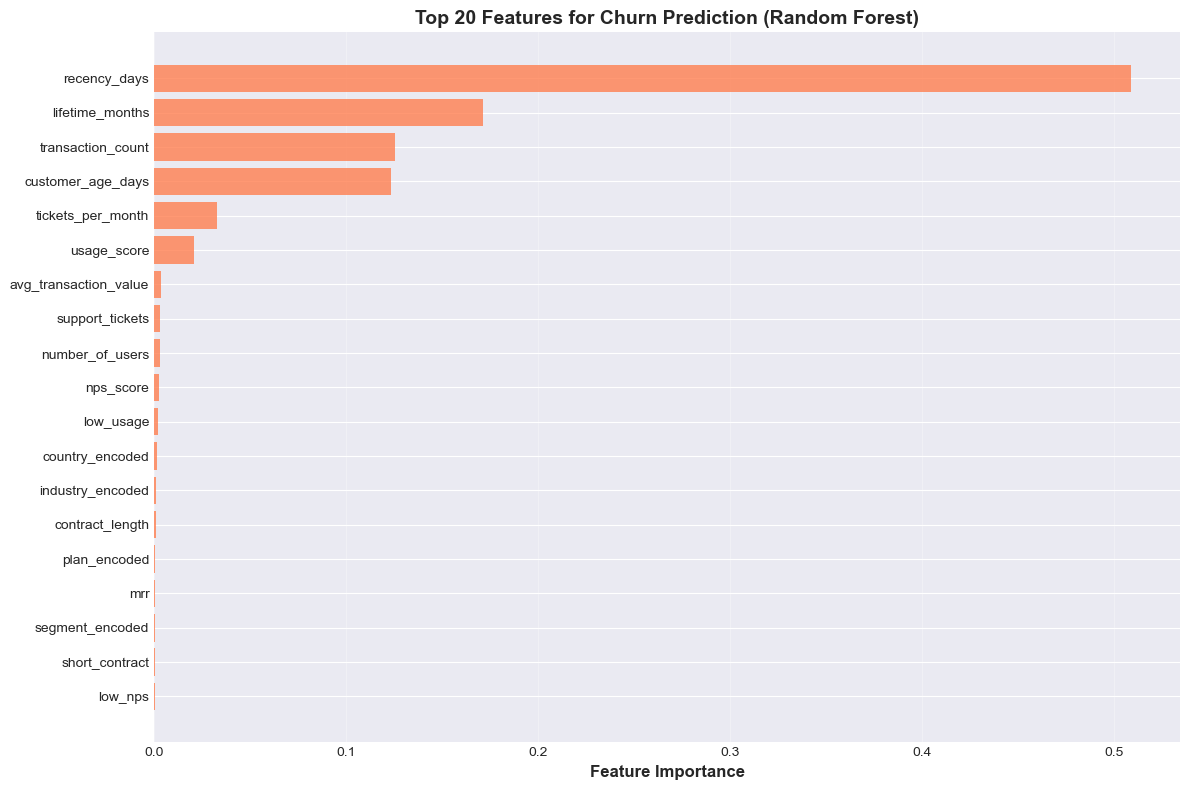


--------------------------------------------------------------------------------
4.7: CUSTOMER RISK STRATIFICATION
--------------------------------------------------------------------------------

 Customer Risk Stratification:

                Total_Customers  Actual_Churned  Churn_Rate  Total_MRR   Total_CLV
risk_category                                                                     
Low Risk                   2663            0.00        0.00     740587 15624765.37
Medium Risk                   4            4.00      100.00        296     3834.58
High Risk                     2            2.00      100.00        548     9182.88
Very High Risk              650          650.00      100.00     166200  2171774.91

 At-Risk Customer Summary:
   • Total At-Risk Customers: 652
   • At-Risk MRR: $166,748.00/month
   • Annual Revenue at Risk: $2,000,976.00
   • Average CLV at Risk: $3,345.03

 Top 50 Highest Risk Customers:
customer_id        segment         plan  mrr  usage_score  nps

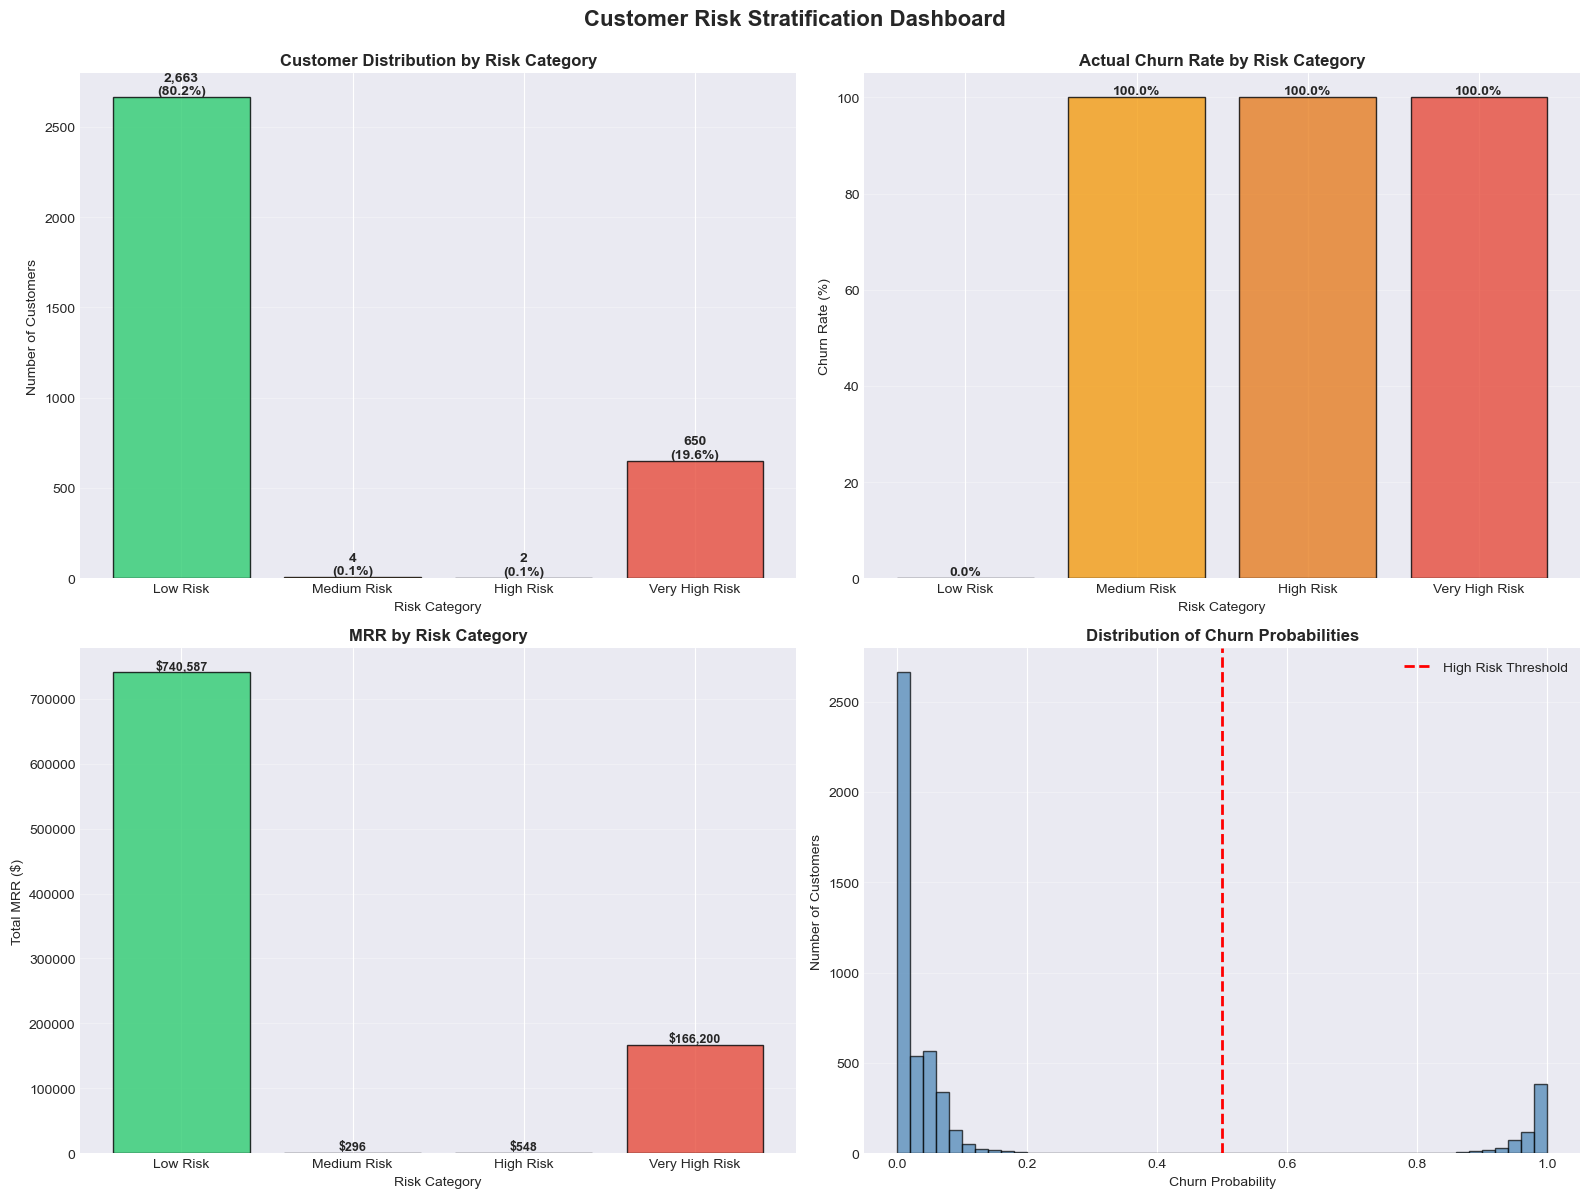


 Churn Analysis Complete!



In [5]:
# ============================================================================
# SECTION 4: CUSTOMER CHURN ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 4: CUSTOMER CHURN ANALYSIS & PREDICTION")
print("="*80)

print("""
Churn analysis helps us:
1. Identify customers at risk of leaving
2. Understand key churn drivers
3. Calculate financial impact of churn
4. Develop retention strategies

We'll analyze:
  • Churn rates by segment and cohort
  • Predictive models for churn risk
  • Customer lifetime value impact
  • Intervention opportunities
""")

# ========================================================================
# 4.1: CHURN OVERVIEW & STATISTICS
# ========================================================================

print("\n" + "-"*80)
print("4.1: CHURN OVERVIEW & STATISTICS")
print("-"*80)

# Overall churn metrics
total_customers = len(customers)
churned_customers = customers['is_churned'].sum()
active_customers = total_customers - churned_customers
overall_churn_rate = (churned_customers / total_customers) * 100

print(f"\n Overall Churn Metrics:")
print(f"   • Total Customers: {total_customers:,}")
print(f"   • Active Customers: {active_customers:,} ({active_customers/total_customers*100:.1f}%)")
print(f"   • Churned Customers: {churned_customers:,} ({overall_churn_rate:.1f}%)")

# Churn by segment
print(f"\n Churn Rate by Customer Segment:")
churn_by_segment = customers.groupby('segment').agg({
    'is_churned': ['sum', 'mean', 'count']
})
churn_by_segment.columns = ['Churned_Count', 'Churn_Rate', 'Total_Customers']
churn_by_segment['Churn_Rate'] = churn_by_segment['Churn_Rate'] * 100
churn_by_segment = churn_by_segment.sort_values('Churn_Rate', ascending=False)
print(churn_by_segment.to_string())

# Churn by plan
print(f"\n Churn Rate by Subscription Plan:")
churn_by_plan = customers.groupby('plan').agg({
    'is_churned': ['sum', 'mean', 'count']
})
churn_by_plan.columns = ['Churned_Count', 'Churn_Rate', 'Total_Customers']
churn_by_plan['Churn_Rate'] = churn_by_plan['Churn_Rate'] * 100
churn_by_plan = churn_by_plan.sort_values('Churn_Rate', ascending=False)
print(churn_by_plan.to_string())

# Financial impact of churn
churned_mrr = customers[customers['is_churned'] == 1]['mrr'].sum()
churned_clv = customers[customers['is_churned'] == 1]['clv'].sum()

print(f"\n Financial Impact of Churn:")
print(f"   • Lost MRR: ${churned_mrr:,.2f}/month")
print(f"   • Annual Revenue Impact: ${churned_mrr * 12:,.2f}/year")
print(f"   • Total CLV Lost: ${churned_clv:,.2f}")

# ========================================================================
# 4.2: CHURN ANALYSIS VISUALIZATIONS
# ========================================================================

print("\n" + "-"*80)
print("4.2: CHURN ANALYSIS VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Churn Rate by Segment
ax1 = fig.add_subplot(gs[0, 0])
colors_churn = ['#e74c3c' if x > overall_churn_rate else '#2ecc71' 
                for x in churn_by_segment['Churn_Rate']]
ax1.bar(churn_by_segment.index, churn_by_segment['Churn_Rate'], 
        color=colors_churn, alpha=0.8, edgecolor='black')
ax1.axhline(y=overall_churn_rate, color='blue', linestyle='--', 
            label=f'Overall: {overall_churn_rate:.1f}%', linewidth=2)
ax1.set_title('Churn Rate by Segment', fontweight='bold', fontsize=12)
ax1.set_ylabel('Churn Rate (%)')
ax1.set_xlabel('Segment')
for i, v in enumerate(churn_by_segment['Churn_Rate']):
    ax1.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Churn Rate by Contract Length
ax2 = fig.add_subplot(gs[0, 1])
churn_by_contract = customers.groupby('contract_length')['is_churned'].mean() * 100
churn_by_contract = churn_by_contract.sort_index()
ax2.plot(churn_by_contract.index, churn_by_contract.values, 
         marker='o', linewidth=2.5, markersize=10, color='#e74c3c')
ax2.set_title('Churn Rate by Contract Length', fontweight='bold', fontsize=12)
ax2.set_xlabel('Contract Length (months)')
ax2.set_ylabel('Churn Rate (%)')
ax2.grid(True, alpha=0.3)
for x, y in zip(churn_by_contract.index, churn_by_contract.values):
    ax2.text(x, y, f'{y:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Usage Score Distribution: Churned vs Active
ax3 = fig.add_subplot(gs[0, 2])
churned_usage = customers[customers['is_churned'] == 1]['usage_score']
active_usage = customers[customers['is_churned'] == 0]['usage_score']
ax3.hist([active_usage, churned_usage], bins=25, label=['Active', 'Churned'],
         color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax3.axvline(active_usage.mean(), color='green', linestyle='--', linewidth=2,
            label=f'Active Mean: {active_usage.mean():.1f}')
ax3.axvline(churned_usage.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Churned Mean: {churned_usage.mean():.1f}')
ax3.set_title('Usage Score: Active vs Churned', fontweight='bold', fontsize=12)
ax3.set_xlabel('Usage Score')
ax3.set_ylabel('Number of Customers')
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# 4. NPS Score Distribution
ax4 = fig.add_subplot(gs[1, 0])
churned_nps = customers[customers['is_churned'] == 1]['nps_score']
active_nps = customers[customers['is_churned'] == 0]['nps_score']
ax4.hist([active_nps, churned_nps], bins=25, label=['Active', 'Churned'],
         color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax4.axvline(active_nps.mean(), color='green', linestyle='--', linewidth=2,
            label=f'Active Mean: {active_nps.mean():.1f}')
ax4.axvline(churned_nps.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Churned Mean: {churned_nps.mean():.1f}')
ax4.set_title('NPS Score: Active vs Churned', fontweight='bold', fontsize=12)
ax4.set_xlabel('NPS Score')
ax4.set_ylabel('Number of Customers')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

# 5. Support Tickets vs Churn
ax5 = fig.add_subplot(gs[1, 1])
churn_by_tickets = customers.groupby('support_tickets')['is_churned'].mean() * 100
ax5.bar(churn_by_tickets.index, churn_by_tickets.values, 
        color='#e74c3c', alpha=0.7, edgecolor='black')
ax5.set_title('Churn Rate by Support Tickets', fontweight='bold', fontsize=12)
ax5.set_xlabel('Number of Support Tickets')
ax5.set_ylabel('Churn Rate (%)')
ax5.grid(axis='y', alpha=0.3)

# 6. Customer Lifetime by Churn Status
ax6 = fig.add_subplot(gs[1, 2])
churned_lifetime = customers[customers['is_churned'] == 1]['lifetime_months']
active_lifetime = customers[customers['is_churned'] == 0]['lifetime_months']
bp = ax6.boxplot([active_lifetime, churned_lifetime], 
                  labels=['Active', 'Churned'],
                  patch_artist=True,
                  showmeans=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
ax6.set_title('Customer Lifetime Distribution', fontweight='bold', fontsize=12)
ax6.set_ylabel('Lifetime (months)')
ax6.grid(axis='y', alpha=0.3)

# 7. Churn by Industry
ax7 = fig.add_subplot(gs[2, :])
churn_by_industry = customers.groupby('industry').agg({
    'is_churned': ['mean', 'count']
})
churn_by_industry.columns = ['Churn_Rate', 'Count']
churn_by_industry = churn_by_industry[churn_by_industry['Count'] >= 50]  # Filter small groups
churn_by_industry['Churn_Rate'] = churn_by_industry['Churn_Rate'] * 100
churn_by_industry = churn_by_industry.sort_values('Churn_Rate', ascending=True)

colors_industry = ['#e74c3c' if x > overall_churn_rate else '#2ecc71' 
                   for x in churn_by_industry['Churn_Rate']]
ax7.barh(churn_by_industry.index, churn_by_industry['Churn_Rate'],
         color=colors_industry, alpha=0.7, edgecolor='black')
ax7.axvline(x=overall_churn_rate, color='blue', linestyle='--',
            label=f'Overall: {overall_churn_rate:.1f}%', linewidth=2)
ax7.set_title('Churn Rate by Industry', fontweight='bold', fontsize=12)
ax7.set_xlabel('Churn Rate (%)')
ax7.legend()
ax7.grid(axis='x', alpha=0.3)
for i, v in enumerate(churn_by_industry['Churn_Rate']):
    ax7.text(v, i, f' {v:.1f}%', va='center', fontweight='bold', fontsize=9)

plt.suptitle('Customer Churn Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('financial_viz/07_churn_analysis.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/07_churn_analysis.png")
plt.show()

# ========================================================================
# 4.3: FEATURE ENGINEERING FOR CHURN PREDICTION
# ========================================================================

print("\n" + "-"*80)
print("4.3: FEATURE ENGINEERING FOR CHURN PREDICTION")
print("-"*80)

print("\nCreating predictive features...")

# Create a copy for modeling
churn_model_data = customers.copy()

# Calculate customer age (days since signup)
churn_model_data['customer_age_days'] = (
    pd.to_datetime('2024-12-31') - churn_model_data['signup_date']
).dt.days

# Engagement metrics
churn_model_data['avg_revenue_per_month'] = (
    churn_model_data['total_revenue'] / churn_model_data['lifetime_months']
)

# Tickets per month
churn_model_data['tickets_per_month'] = (
    churn_model_data['support_tickets'] / churn_model_data['lifetime_months']
)

# Low engagement flag
churn_model_data['low_usage'] = (churn_model_data['usage_score'] < 40).astype(int)
churn_model_data['low_nps'] = (churn_model_data['nps_score'] < 0).astype(int)

# Contract risk
churn_model_data['short_contract'] = (churn_model_data['contract_length'] <= 1).astype(int)

print(" Created engagement and risk features")

# Select features for modeling
feature_columns = [
    'mrr', 'contract_length', 'number_of_users', 'support_tickets',
    'usage_score', 'nps_score', 'customer_age_days', 'lifetime_months',
    'transaction_count', 'avg_transaction_value', 'recency_days',
    'tickets_per_month', 'low_usage', 'low_nps', 'short_contract'
]

# Add categorical features (will be encoded)
categorical_features = ['segment', 'industry', 'plan', 'country']

print(f"\n Feature Set:")
print(f"   • Numeric Features: {len(feature_columns)}")
print(f"   • Categorical Features: {len(categorical_features)}")

# Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    churn_model_data[f'{col}_encoded'] = le.fit_transform(churn_model_data[col].astype(str))
    label_encoders[col] = le
    feature_columns.append(f'{col}_encoded')

print(f"   • Total Features: {len(feature_columns)}")

# Prepare X and y
X = churn_model_data[feature_columns].fillna(0)
y = churn_model_data['is_churned']

print(f"\n Dataset for Modeling:")
print(f"   • Total Samples: {len(X):,}")
print(f"   • Features: {X.shape[1]}")
print(f"   • Churned (Class 1): {y.sum():,} ({y.mean()*100:.1f}%)")
print(f"   • Active (Class 0): {(1-y).sum():,} ({(1-y.mean())*100:.1f}%)")

# ========================================================================
# 4.4: TRAIN CHURN PREDICTION MODELS
# ========================================================================

print("\n" + "-"*80)
print("4.4: CHURN PREDICTION MODEL TRAINING")
print("-"*80)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData Split:")
print(f"   • Training Set: {len(X_train):,} samples")
print(f"   • Test Set: {len(X_test):,} samples")

# Clean inf/nan before scaling
for df in [X_train, X_test]:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.median(), inplace=True)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n Training Multiple Models...")

# Dictionary to store models and results
churn_models = {}
churn_results = {}

# 1. Logistic Regression
print("\n Logistic Regression...")
lr_churn = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_churn.fit(X_train_scaled, y_train)
lr_pred = lr_churn.predict(X_test_scaled)
lr_pred_proba = lr_churn.predict_proba(X_test_scaled)[:, 1]

churn_models['Logistic Regression'] = lr_churn
churn_results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test, lr_pred),
    'roc_auc': roc_auc_score(y_test, lr_pred_proba)
}

print(f"   Accuracy: {churn_results['Logistic Regression']['accuracy']:.4f}")
print(f"   ROC AUC: {churn_results['Logistic Regression']['roc_auc']:.4f}")

# 2. Random Forest
print("\n Random Forest Classifier...")
rf_churn = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_churn.fit(X_train, y_train)
rf_pred = rf_churn.predict(X_test)
rf_pred_proba = rf_churn.predict_proba(X_test)[:, 1]

churn_models['Random Forest'] = rf_churn
churn_results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'roc_auc': roc_auc_score(y_test, rf_pred_proba)
}

print(f"   Accuracy: {churn_results['Random Forest']['accuracy']:.4f}")
print(f"   ROC AUC: {churn_results['Random Forest']['roc_auc']:.4f}")

# 3. Gradient Boosting
print("\n Gradient Boosting Classifier...")
gb_churn = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gb_churn.fit(X_train, y_train)
gb_pred = gb_churn.predict(X_test)
gb_pred_proba = gb_churn.predict_proba(X_test)[:, 1]

churn_models['Gradient Boosting'] = gb_churn
churn_results['Gradient Boosting'] = {
    'accuracy': accuracy_score(y_test, gb_pred),
    'precision': precision_score(y_test, gb_pred),
    'recall': recall_score(y_test, gb_pred),
    'f1': f1_score(y_test, gb_pred),
    'roc_auc': roc_auc_score(y_test, gb_pred_proba)
}

print(f"   Accuracy: {churn_results['Gradient Boosting']['accuracy']:.4f}")
print(f"   ROC AUC: {churn_results['Gradient Boosting']['roc_auc']:.4f}")

# ========================================================================
# 4.5: MODEL COMPARISON & EVALUATION
# ========================================================================

print("\n" + "-"*80)
print("4.5: MODEL COMPARISON & EVALUATION")
print("-"*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame(churn_results).T
print("\n Model Performance Comparison:\n")
print(comparison_df.round(4))

# Determine best model
best_churn_model_name = comparison_df['roc_auc'].idxmax()
print(f"\n Best Model: {best_churn_model_name}")
print(f"   ROC AUC: {comparison_df.loc[best_churn_model_name, 'roc_auc']:.4f}")

# Get best model predictions
if best_churn_model_name == 'Logistic Regression':
    best_pred = lr_pred
    best_pred_proba = lr_pred_proba
elif best_churn_model_name == 'Random Forest':
    best_pred = rf_pred
    best_pred_proba = rf_pred_proba
else:
    best_pred = gb_pred
    best_pred_proba = gb_pred_proba

# Detailed classification report
print("\n" + "-"*80)
print(f"DETAILED CLASSIFICATION REPORT - {best_churn_model_name}")
print("-"*80)
print(classification_report(y_test, best_pred, 
                          target_names=['Active', 'Churned'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, best_pred)
tn, fp, fn, tp = cm.ravel()

print("\n Confusion Matrix:")
print(f"   • True Negatives (TN): {tn:,} - Correctly predicted active")
print(f"   • False Positives (FP): {fp:,} - Incorrectly predicted churn")
print(f"   • False Negatives (FN): {fn:,} - Missed churns (costly)")
print(f"   • True Positives (TP): {tp:,} - Correctly predicted churn")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Metrics comparison
ax1 = axes[0, 0]
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison_df[metrics_to_plot].T.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Model Performance Metrics', fontweight='bold', fontsize=12)
ax1.set_ylabel('Score')
ax1.set_xlabel('Metric')
ax1.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'], rotation=45)
ax1.legend(title='Model', loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. ROC Curves
ax2 = axes[0, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_pred_proba)

ax2.plot(fpr_lr, tpr_lr, label=f'LR (AUC={churn_results["Logistic Regression"]["roc_auc"]:.3f})',
         linewidth=2.5, color='#3498db')
ax2.plot(fpr_rf, tpr_rf, label=f'RF (AUC={churn_results["Random Forest"]["roc_auc"]:.3f})',
         linewidth=2.5, color='#e74c3c')
ax2.plot(fpr_gb, tpr_gb, label=f'GB (AUC={churn_results["Gradient Boosting"]["roc_auc"]:.3f})',
         linewidth=2.5, color='#2ecc71')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.set_title('ROC Curves - Churn Prediction', fontweight='bold', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

# 3. Confusion Matrix Heatmap
ax3 = axes[1, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax3,
            xticklabels=['Active', 'Churned'],
            yticklabels=['Active', 'Churned'],
            cbar_kws={'label': 'Count'})
ax3.set_title(f'Confusion Matrix - {best_churn_model_name}', fontweight='bold', fontsize=12)
ax3.set_ylabel('True Label', fontweight='bold')
ax3.set_xlabel('Predicted Label', fontweight='bold')

# 4. Probability Distribution
ax4 = axes[1, 1]
churned_probs = best_pred_proba[y_test == 1]
active_probs = best_pred_proba[y_test == 0]
ax4.hist([active_probs, churned_probs], bins=30, 
         label=['Active (Actual)', 'Churned (Actual)'],
         color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
ax4.set_title('Churn Probability Distribution', fontweight='bold', fontsize=12)
ax4.set_xlabel('Predicted Churn Probability')
ax4.set_ylabel('Number of Customers')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Churn Prediction Model Evaluation', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('financial_viz/08_churn_model_evaluation.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/08_churn_model_evaluation.png")
plt.show()

# ========================================================================
# 4.6: FEATURE IMPORTANCE ANALYSIS
# ========================================================================

print("\n" + "-"*80)
print("4.6: FEATURE IMPORTANCE ANALYSIS")
print("-"*80)

# Get feature importance from Random Forest (most interpretable)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_churn.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 15 Most Important Features for Churn Prediction:\n")
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='coral', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontweight='bold', fontsize=12)
plt.title('Top 20 Features for Churn Prediction (Random Forest)', 
          fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('financial_viz/09_churn_feature_importance.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/09_churn_feature_importance.png")
plt.show()

# ========================================================================
# 4.7: CUSTOMER RISK STRATIFICATION
# ========================================================================

print("\n" + "-"*80)
print("4.7: CUSTOMER RISK STRATIFICATION")
print("-"*80)

# Clean the data before prediction
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Add predictions to full dataset
churn_model_data['churn_probability'] = churn_models[best_churn_model_name].predict_proba(
    X.fillna(0) if best_churn_model_name == 'Logistic Regression' 
    else X.fillna(0)
)[:, 1] if best_churn_model_name != 'Logistic Regression' else churn_models[best_churn_model_name].predict_proba(
    scaler.transform(X.fillna(0))
)[:, 1]

# Create risk categories
churn_model_data['risk_category'] = pd.cut(
    churn_model_data['churn_probability'],
    bins=[0, 0.25, 0.50, 0.75, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
)

# Analyze risk categories
risk_analysis = churn_model_data.groupby('risk_category').agg({
    'customer_id': 'count',
    'is_churned': ['sum', 'mean'],
    'mrr': 'sum',
    'clv': 'sum'
})
risk_analysis.columns = ['Total_Customers', 'Actual_Churned', 'Churn_Rate', 'Total_MRR', 'Total_CLV']
risk_analysis['Churn_Rate'] = risk_analysis['Churn_Rate'] * 100

print("\n Customer Risk Stratification:\n")
print(risk_analysis.to_string())

# At-risk customers (High + Very High Risk)
at_risk = churn_model_data[churn_model_data['churn_probability'] >= 0.5]
at_risk_mrr = at_risk['mrr'].sum()

print(f"\n At-Risk Customer Summary:")
print(f"   • Total At-Risk Customers: {len(at_risk):,}")
print(f"   • At-Risk MRR: ${at_risk_mrr:,.2f}/month")
print(f"   • Annual Revenue at Risk: ${at_risk_mrr * 12:,.2f}")
print(f"   • Average CLV at Risk: ${at_risk['clv'].mean():,.2f}")

# Top 50 highest risk customers
top_risk_customers = churn_model_data.nlargest(50, 'churn_probability')[[
    'customer_id', 'segment', 'plan', 'mrr', 'usage_score', 
    'nps_score', 'churn_probability', 'risk_category'
]]

print(f"\n Top 50 Highest Risk Customers:")
print(top_risk_customers.head(20).to_string(index=False))

# Save at-risk customer list
at_risk_export = churn_model_data[churn_model_data['churn_probability'] >= 0.5][[
    'customer_id', 'segment', 'industry', 'plan', 'mrr', 'clv',
    'usage_score', 'nps_score', 'support_tickets', 'churn_probability', 'risk_category'
]].sort_values('churn_probability', ascending=False)

at_risk_export.to_csv('at_risk_customers.csv', index=False)
print(f"\n Saved at-risk customer list to: 'at_risk_customers.csv'")

# Visualize risk stratification
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Customer distribution by risk
ax1 = axes[0, 0]
risk_counts = risk_analysis['Total_Customers']
colors_risk = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
ax1.bar(risk_counts.index, risk_counts.values, color=colors_risk, alpha=0.8, edgecolor='black')
ax1.set_title('Customer Distribution by Risk Category', fontweight='bold', fontsize=12)
ax1.set_ylabel('Number of Customers')
ax1.set_xlabel('Risk Category')
for i, v in enumerate(risk_counts.values):
    ax1.text(i, v, f'{v:,}\n({v/risk_counts.sum()*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 2. Actual churn rate by risk category
ax2 = axes[0, 1]
ax2.bar(risk_analysis.index, risk_analysis['Churn_Rate'], 
        color=colors_risk, alpha=0.8, edgecolor='black')
ax2.set_title('Actual Churn Rate by Risk Category', fontweight='bold', fontsize=12)
ax2.set_ylabel('Churn Rate (%)')
ax2.set_xlabel('Risk Category')
for i, v in enumerate(risk_analysis['Churn_Rate']):
    ax2.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. MRR at risk
ax3 = axes[1, 0]
ax3.bar(risk_analysis.index, risk_analysis['Total_MRR'], 
        color=colors_risk, alpha=0.8, edgecolor='black')
ax3.set_title('MRR by Risk Category', fontweight='bold', fontsize=12)
ax3.set_ylabel('Total MRR ($)')
ax3.set_xlabel('Risk Category')
for i, v in enumerate(risk_analysis['Total_MRR']):
    ax3.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# 4. Churn probability distribution
ax4 = axes[1, 1]
ax4.hist(churn_model_data['churn_probability'], bins=50, color='steelblue', 
         alpha=0.7, edgecolor='black')
ax4.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='High Risk Threshold')
ax4.set_title('Distribution of Churn Probabilities', fontweight='bold', fontsize=12)
ax4.set_xlabel('Churn Probability')
ax4.set_ylabel('Number of Customers')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Customer Risk Stratification Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('financial_viz/10_risk_stratification.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/10_risk_stratification.png")
plt.show()

print("\n Churn Analysis Complete!")
print("="*80 + "\n")

In [6]:
## Check for NaNs or infinite values - If Needed
print("Any NaNs?", np.isnan(X_train).any().any())
print("Any +inf?", np.isinf(X_train).any().any())
print("Any -inf?", np.isneginf(X_train).any().any())

Any NaNs? False
Any +inf? False
Any -inf? False



SECTION 5: COHORT & RETENTION ANALYSIS

Cohort analysis helps us understand:
1. How different customer groups perform over time
2. Retention rates by acquisition period
3. Revenue patterns by cohort
4. Customer lifetime value trends

We'll analyze:
  • Monthly cohort retention
  • Revenue retention by cohort
  • Cohort lifetime value
  • RFM segmentation


--------------------------------------------------------------------------------
5.1: COHORT RETENTION ANALYSIS
--------------------------------------------------------------------------------

Calculating monthly cohort retention rates...

 Cohort Retention Matrix (%):

cohort_index     0      1      2      3      4      5      6      7     8   \
cohort_month                                                                 
2020-01      100.00 100.00 100.00 100.00  99.00  99.00  96.90  96.90 96.90   
2020-02      100.00    NaN 100.00 100.00  96.10  94.70  94.70  93.40 93.40   
2020-03      100.00 100.00 100.00 100.00 100.00 100.00 1

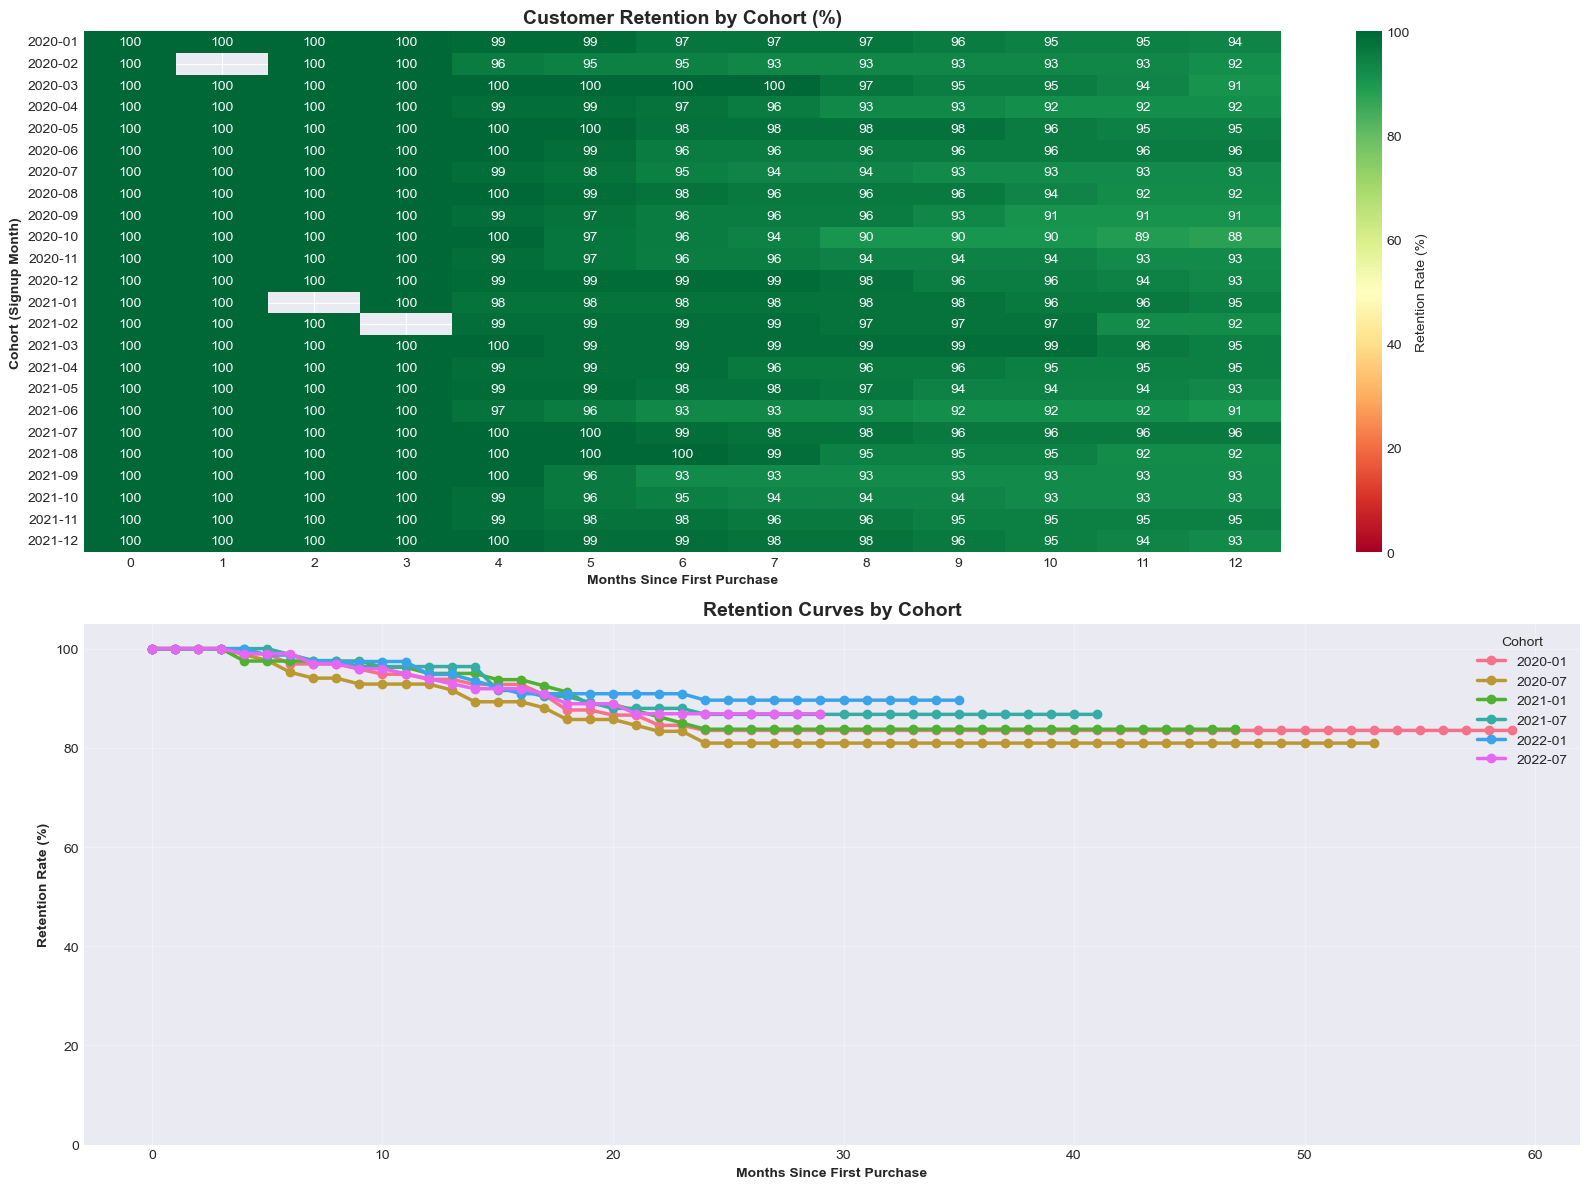


--------------------------------------------------------------------------------
5.3: REVENUE COHORT ANALYSIS
--------------------------------------------------------------------------------

Calculating revenue by cohort over time...

 Average Revenue per Customer by Cohort Month:

cohort_index      0      1      2      3      4      5      6
cohort_month                                                 
2020-01      225.55 230.53 225.75 225.45 227.76 228.31 232.87
2020-02      538.47    NaN 269.43 270.29 258.25 248.82 251.18
2020-03      200.92 200.87 201.40 201.16 203.24 199.77 197.73
2020-04      270.05 262.50 252.79 258.81 258.96 257.26 250.00
2020-05      305.33 304.13 308.78 303.70 313.24 313.69 301.59
2020-06      226.27 220.58 223.79 223.39 223.69 217.57 226.24
2020-07      219.18 224.96 225.76 224.59 218.79 234.08 231.63
2020-08      199.67 208.51 202.14 203.67 204.51 200.11 202.08
2020-09      251.44 259.10 252.98 261.37 269.71 258.06 264.81
2020-10      282.15 278.48 270.14

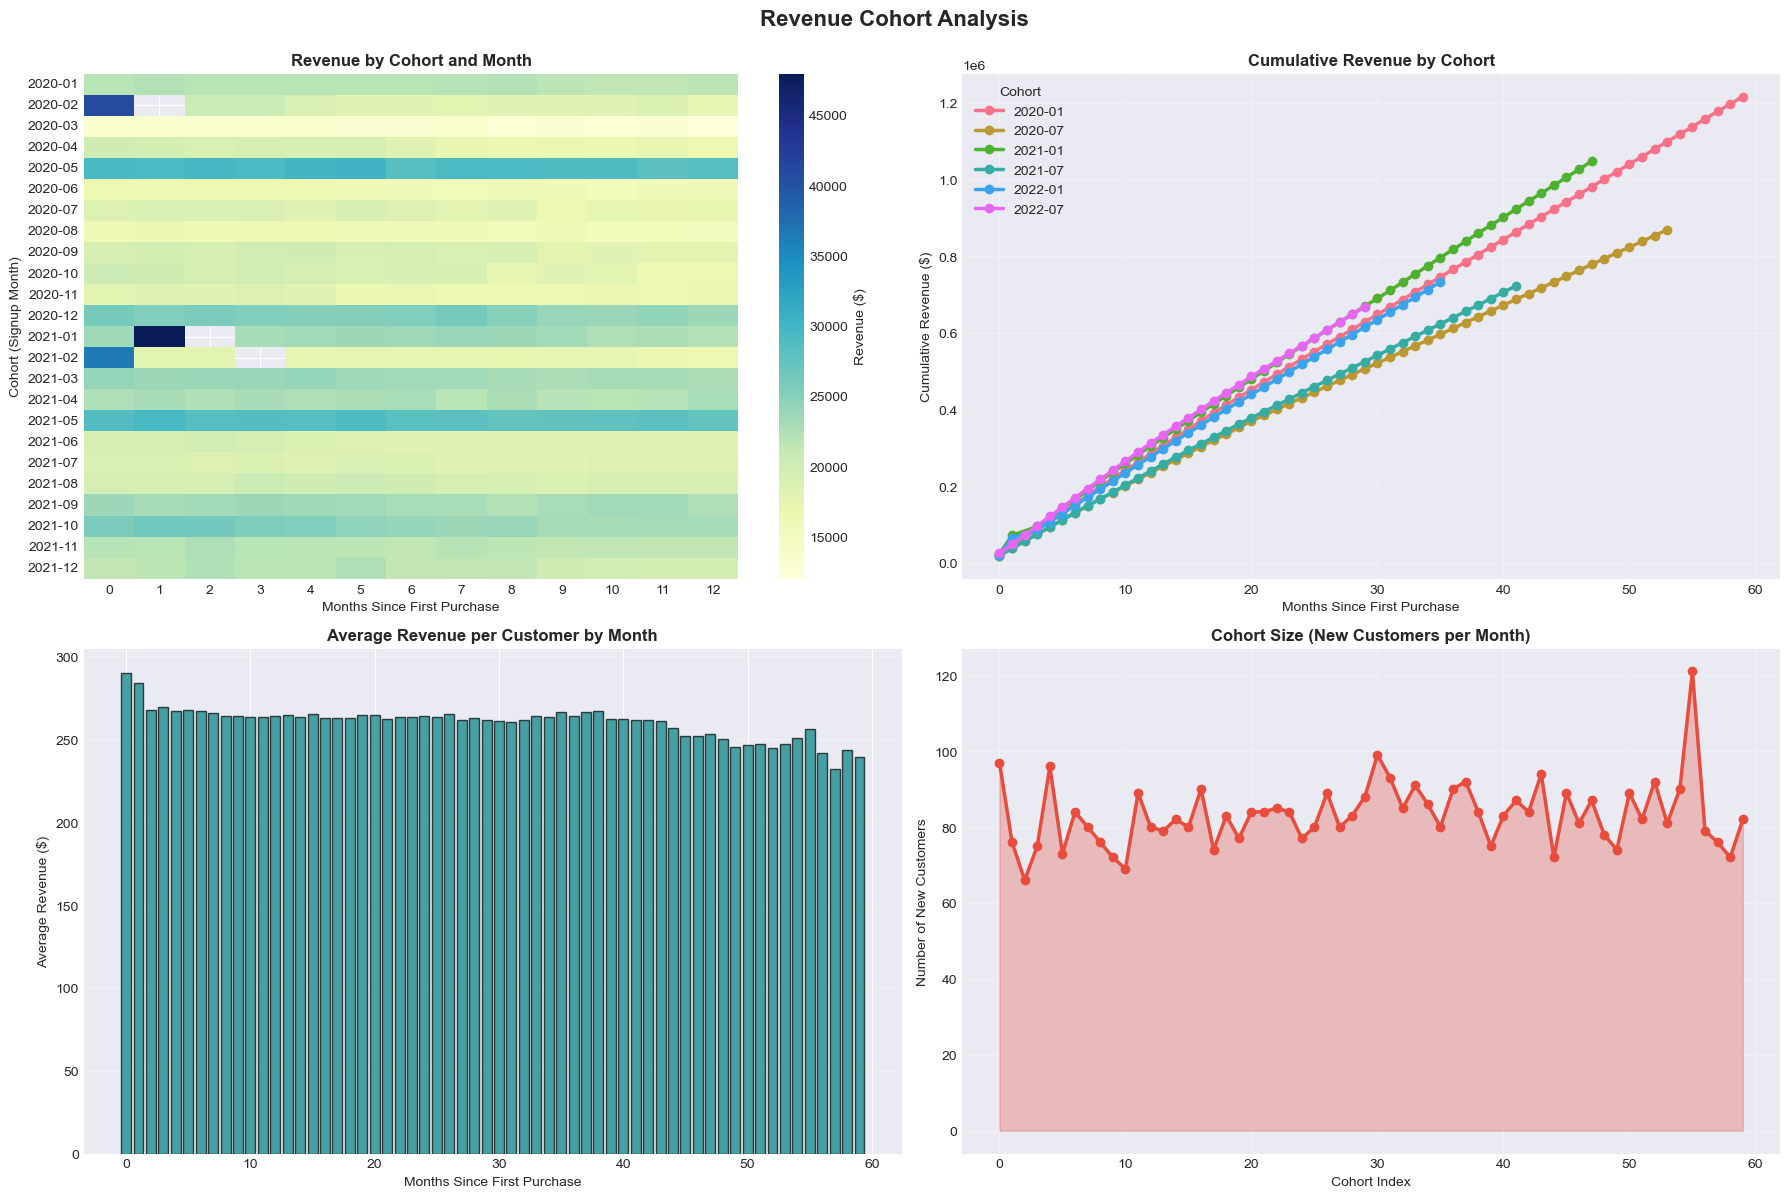


--------------------------------------------------------------------------------
5.4: RFM SEGMENTATION ANALYSIS
--------------------------------------------------------------------------------

RFM Analysis segments customers based on:
  • Recency: How recently did they transact?
  • Frequency: How often do they transact?
  • Monetary: How much do they spend?

This helps identify:
  • Champions (High R, F, M)
  • At-Risk (Low R, High F, M)
  • Lost Customers (Very Low R)
  • New Customers (High R, Low F)


 RFM Customer Segmentation:

                        Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
customer_segment                                                          
At Risk                   730        25.29          43.08      14179.07   
Loyal Customers           780        11.98          40.36      11189.45   
Champions                 470         6.44          46.93      17268.76   
New Customers             707         6.10          11.10       2878.97   
Hibernat

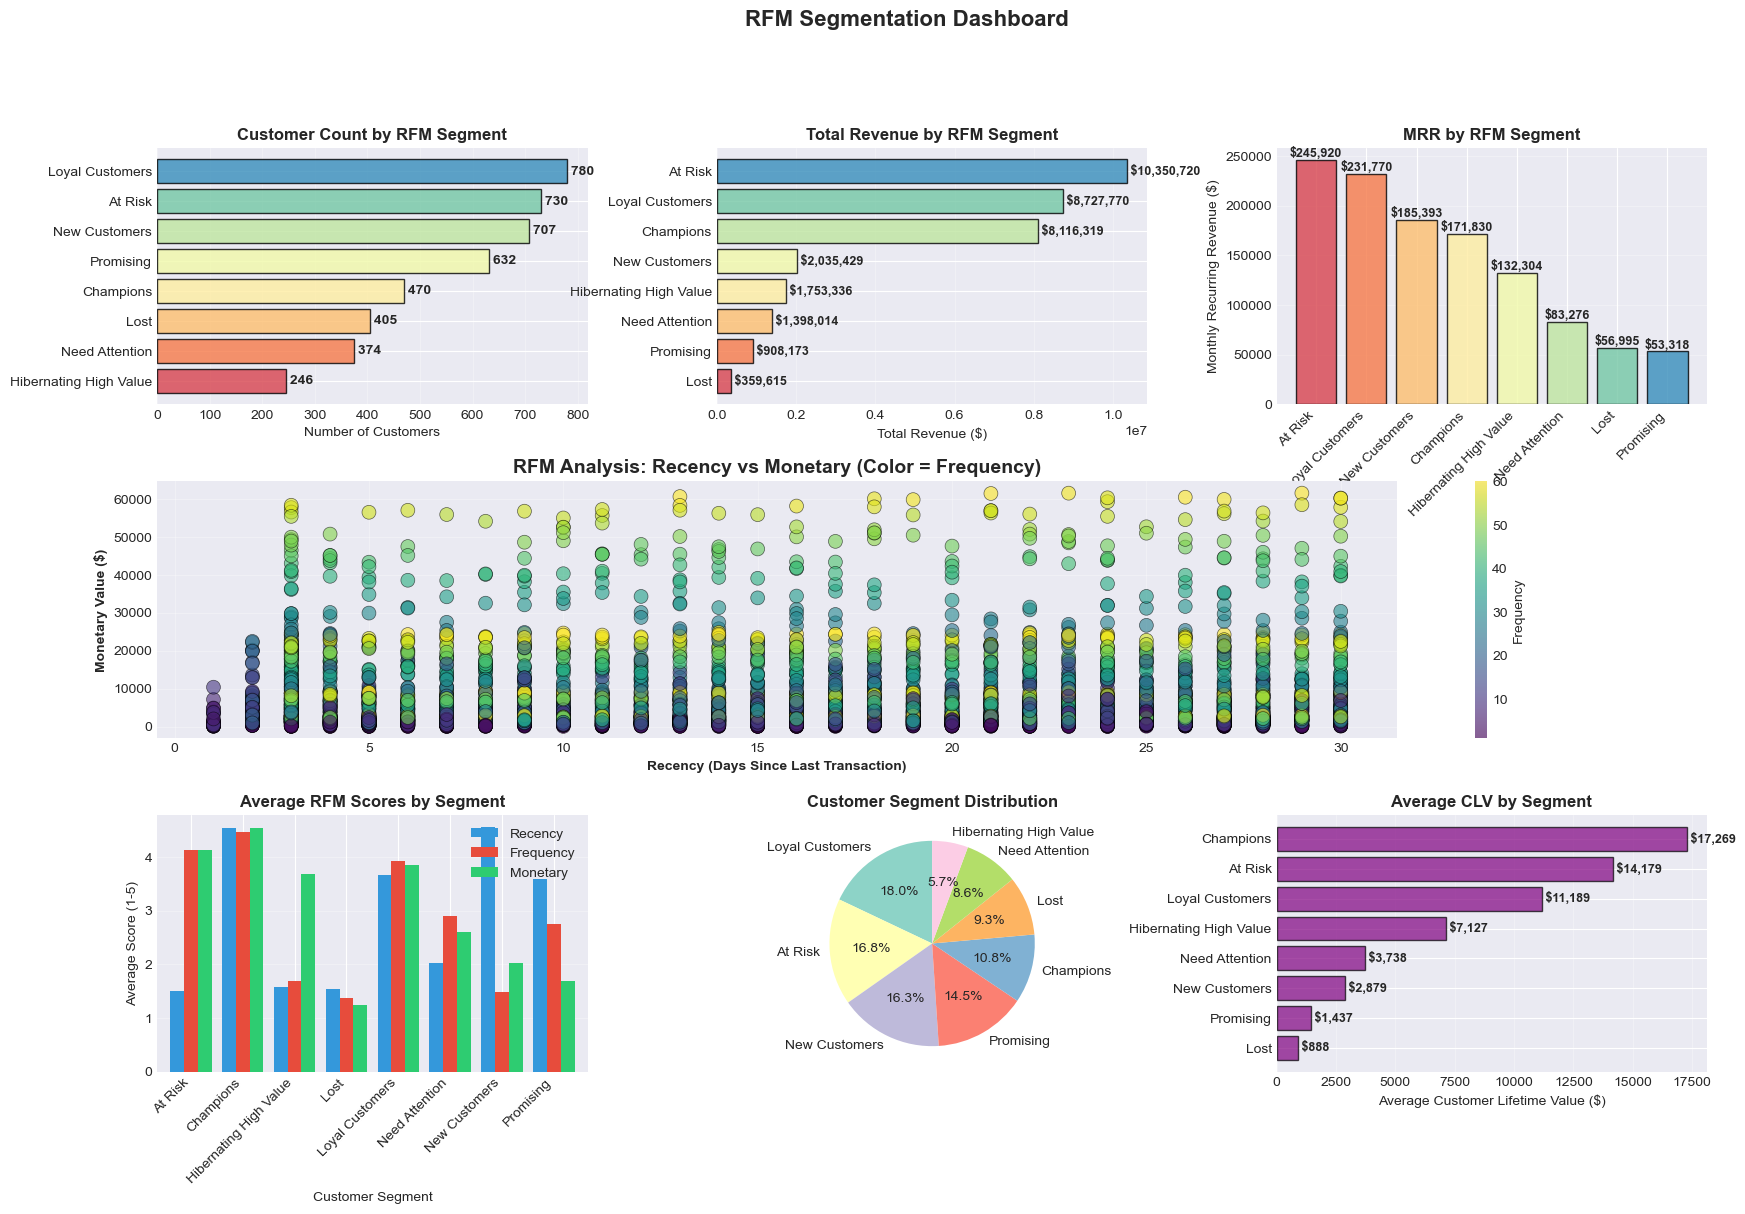


--------------------------------------------------------------------------------
5.5: CUSTOMER LIFETIME VALUE ANALYSIS
--------------------------------------------------------------------------------

Calculating comprehensive CLV metrics...

 CLV by Customer Segment:

                Mean_CLV  Median_CLV  Std_CLV   Total_CLV  Customer_Count  \
segment                                                                     
Enterprise       7010.63     3212.45  8838.75  3596451.92             513   
Mid-Market       7477.64     2916.00 10696.16  9406869.88            1258   
Small Business   7098.99     2826.62  9952.34 14148290.57            1993   
Startup          7024.72     2926.60 10213.24  8682557.18            1236   

                Avg_Lifetime  
segment                       
Enterprise             27.46  
Mid-Market             27.53  
Small Business         26.73  
Startup                26.48  

 CLV by Cohort Year:

             Mean_CLV  Median_CLV   Total_CLV  Customer_C

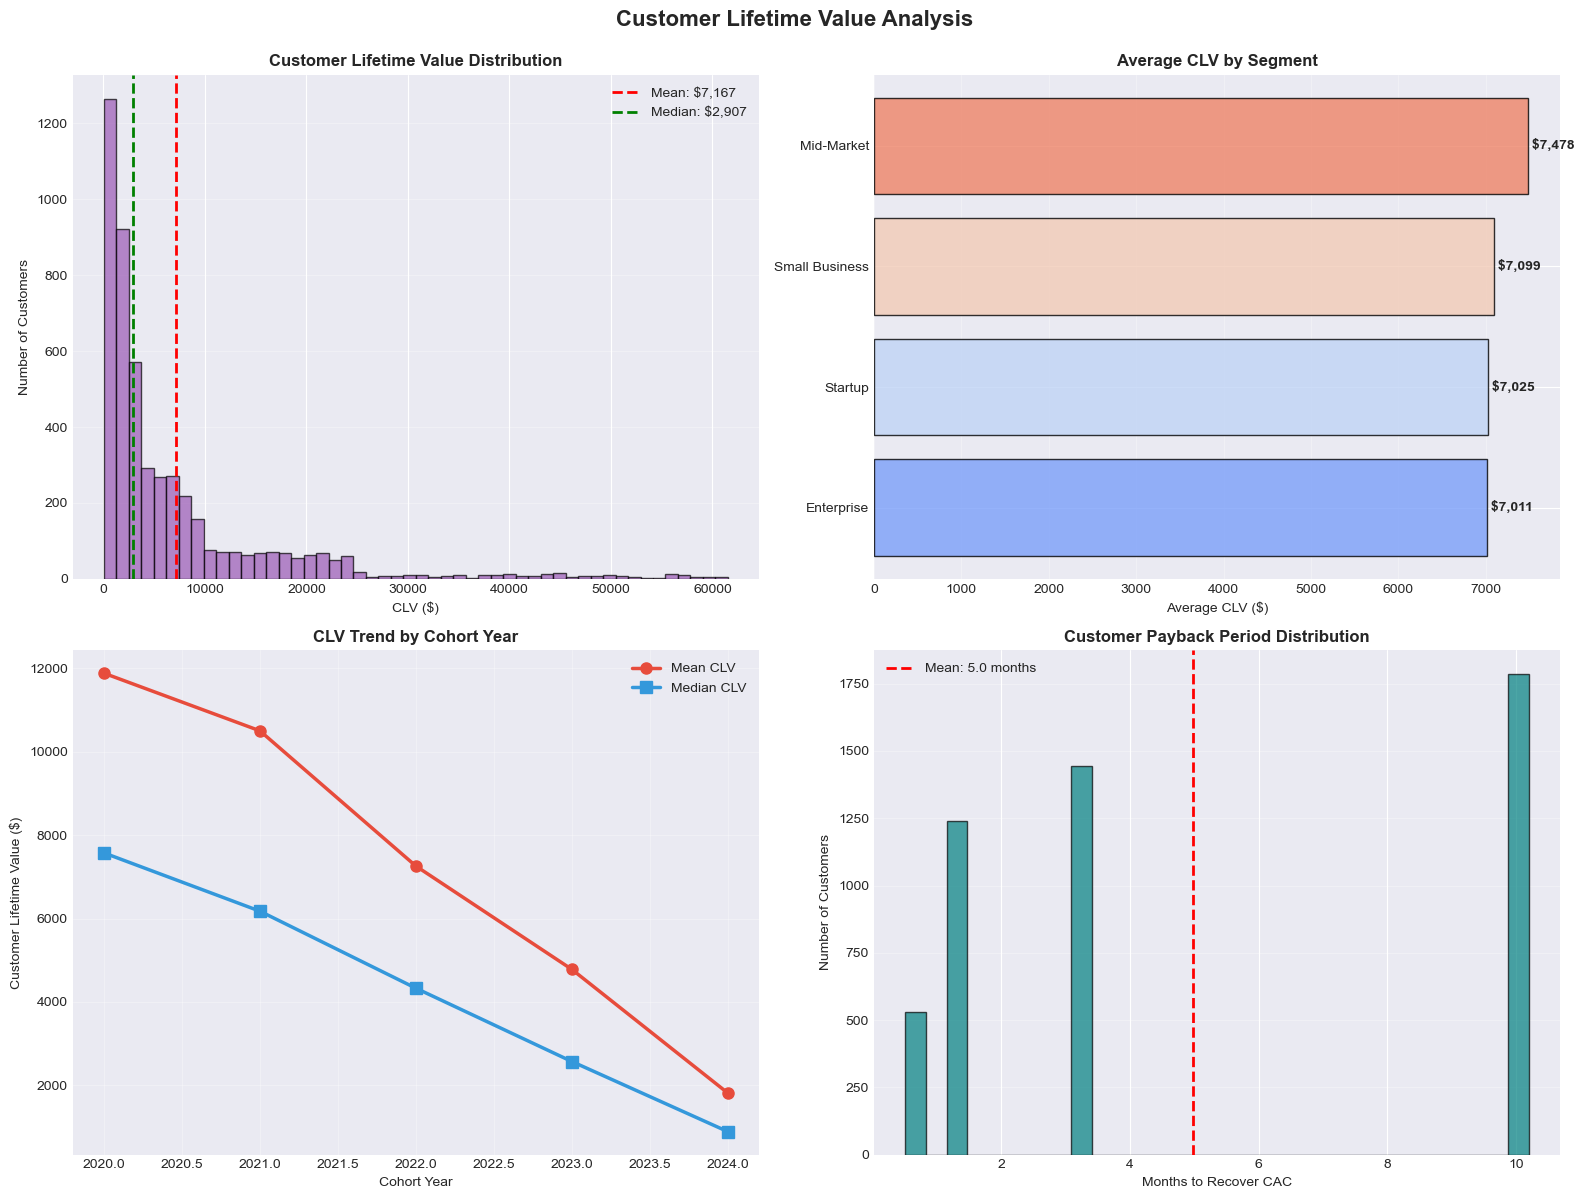


 Cohort & Retention Analysis Complete!



In [7]:
# ============================================================================
# SECTION 5: COHORT & RETENTION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 5: COHORT & RETENTION ANALYSIS")
print("="*80)

print("""
Cohort analysis helps us understand:
1. How different customer groups perform over time
2. Retention rates by acquisition period
3. Revenue patterns by cohort
4. Customer lifetime value trends

We'll analyze:
  • Monthly cohort retention
  • Revenue retention by cohort
  • Cohort lifetime value
  • RFM segmentation
""")

# ========================================================================
# 5.1: COHORT RETENTION ANALYSIS
# ========================================================================

print("\n" + "-"*80)
print("5.1: COHORT RETENTION ANALYSIS")
print("-"*80)

print("\nCalculating monthly cohort retention rates...")

# Create cohort analysis structure
cohort_data = transactions.copy()
cohort_data['cohort_month'] = cohort_data['cohort_month'].astype(str)
cohort_data['transaction_month'] = cohort_data['transaction_month'].astype(str)

# Calculate months since cohort
cohort_data['cohort_index'] = (
    pd.to_datetime(cohort_data['transaction_month']) - 
    pd.to_datetime(cohort_data['cohort_month'])
).dt.days // 30

# Group by cohort and cohort_index
cohort_counts = cohort_data.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().reset_index()
cohort_counts.columns = ['cohort_month', 'cohort_index', 'customer_count']

# Pivot to create retention matrix
retention_matrix = cohort_counts.pivot(index='cohort_month', columns='cohort_index', values='customer_count')

# Calculate retention percentages
cohort_size = retention_matrix.iloc[:, 0]
retention_pct = retention_matrix.divide(cohort_size, axis=0) * 100

print("\n Cohort Retention Matrix (%):\n")
print(retention_pct.iloc[:12, :13].round(1))  # Show first 12 cohorts, 13 months

# Calculate average retention by month
avg_retention = retention_pct.mean(axis=0)
print("\n Average Retention Rate by Month:\n")
for i in range(min(13, len(avg_retention))):
    print(f"   Month {i}: {avg_retention.iloc[i]:.1f}%")

# ========================================================================
# 5.2: COHORT RETENTION VISUALIZATION
# ========================================================================

print("\n" + "-"*80)
print("5.2: COHORT RETENTION VISUALIZATION")
print("-"*80)

# Create cohort heatmap
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# 1. Retention Heatmap
ax1 = axes[0]
sns.heatmap(retention_pct.iloc[:24, :13], annot=True, fmt='.0f', cmap='RdYlGn',
            ax=ax1, cbar_kws={'label': 'Retention Rate (%)'}, vmin=0, vmax=100)
ax1.set_title('Customer Retention by Cohort (%)', fontweight='bold', fontsize=14)
ax1.set_xlabel('Months Since First Purchase', fontweight='bold')
ax1.set_ylabel('Cohort (Signup Month)', fontweight='bold')
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# 2. Retention Curves by Selected Cohorts
ax2 = axes[1]
cohorts_to_plot = retention_pct.index[::6][:6]  # Every 6th cohort, max 6
colors_cohorts = sns.color_palette("husl", len(cohorts_to_plot))

for idx, cohort in enumerate(cohorts_to_plot):
    cohort_data_plot = retention_pct.loc[cohort].dropna()
    ax2.plot(cohort_data_plot.index, cohort_data_plot.values, 
             marker='o', linewidth=2.5, label=cohort, color=colors_cohorts[idx])

ax2.set_title('Retention Curves by Cohort', fontweight='bold', fontsize=14)
ax2.set_xlabel('Months Since First Purchase', fontweight='bold')
ax2.set_ylabel('Retention Rate (%)', fontweight='bold')
ax2.legend(title='Cohort', loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.savefig('financial_viz/11_cohort_retention.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/11_cohort_retention.png")
plt.show()

# ========================================================================
# 5.3: REVENUE COHORT ANALYSIS
# ========================================================================

print("\n" + "-"*80)
print("5.3: REVENUE COHORT ANALYSIS")
print("-"*80)

print("\nCalculating revenue by cohort over time...")

# Revenue by cohort and period
cohort_revenue = cohort_data.groupby(['cohort_month', 'cohort_index'])['amount'].sum().reset_index()
revenue_matrix = cohort_revenue.pivot(index='cohort_month', columns='cohort_index', values='amount')

# Average revenue per cohort per month
avg_revenue_per_customer = revenue_matrix.divide(retention_matrix)

print("\n Average Revenue per Customer by Cohort Month:\n")
print(avg_revenue_per_customer.iloc[:12, :7].round(2))

# Cumulative revenue by cohort
cumulative_revenue = revenue_matrix.cumsum(axis=1)

print("\n Cumulative Revenue by Cohort (First 6 Cohorts, First 12 Months):\n")
print(cumulative_revenue.iloc[:6, :12].round(2))

# Visualize revenue cohorts
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Revenue Heatmap
ax1 = axes[0, 0]
sns.heatmap(revenue_matrix.iloc[:24, :13], annot=False, cmap='YlGnBu',
            ax=ax1, cbar_kws={'label': 'Revenue ($)'}, fmt='.0f')
ax1.set_title('Revenue by Cohort and Month', fontweight='bold', fontsize=12)
ax1.set_xlabel('Months Since First Purchase')
ax1.set_ylabel('Cohort (Signup Month)')

# 2. Cumulative Revenue Curves
ax2 = axes[0, 1]
for idx, cohort in enumerate(cohorts_to_plot):
    if cohort in cumulative_revenue.index:
        cohort_cumrev = cumulative_revenue.loc[cohort].dropna()
        ax2.plot(cohort_cumrev.index, cohort_cumrev.values,
                marker='o', linewidth=2.5, label=cohort, color=colors_cohorts[idx])

ax2.set_title('Cumulative Revenue by Cohort', fontweight='bold', fontsize=12)
ax2.set_xlabel('Months Since First Purchase')
ax2.set_ylabel('Cumulative Revenue ($)')
ax2.legend(title='Cohort', loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Average Revenue per Customer
ax3 = axes[1, 0]
avg_rev_by_month = avg_revenue_per_customer.mean(axis=0).dropna()
ax3.bar(avg_rev_by_month.index, avg_rev_by_month.values, 
        color='teal', alpha=0.7, edgecolor='black')
ax3.set_title('Average Revenue per Customer by Month', fontweight='bold', fontsize=12)
ax3.set_xlabel('Months Since First Purchase')
ax3.set_ylabel('Average Revenue ($)')
ax3.grid(axis='y', alpha=0.3)

# 4. Cohort Size Over Time
ax4 = axes[1, 1]
cohort_sizes = retention_matrix.iloc[:, 0].sort_index()
ax4.plot(range(len(cohort_sizes)), cohort_sizes.values, 
         marker='o', linewidth=2.5, color='#e74c3c')
ax4.fill_between(range(len(cohort_sizes)), cohort_sizes.values, alpha=0.3, color='#e74c3c')
ax4.set_title('Cohort Size (New Customers per Month)', fontweight='bold', fontsize=12)
ax4.set_xlabel('Cohort Index')
ax4.set_ylabel('Number of New Customers')
ax4.grid(True, alpha=0.3)

plt.suptitle('Revenue Cohort Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('financial_viz/12_revenue_cohorts.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/12_revenue_cohorts.png")
plt.show()

# ========================================================================
# 5.4: RFM (RECENCY, FREQUENCY, MONETARY) ANALYSIS
# ========================================================================

print("\n" + "-"*80)
print("5.4: RFM SEGMENTATION ANALYSIS")
print("-"*80)

print("""
RFM Analysis segments customers based on:
  • Recency: How recently did they transact?
  • Frequency: How often do they transact?
  • Monetary: How much do they spend?

This helps identify:
  • Champions (High R, F, M)
  • At-Risk (Low R, High F, M)
  • Lost Customers (Very Low R)
  • New Customers (High R, Low F)
""")

# Calculate RFM scores
reference_date = pd.to_datetime('2024-12-31')

rfm_data = customers[customers['is_churned'] == 0].copy()  # Only active customers

# Recency: Days since last transaction
rfm_data['recency'] = rfm_data['recency_days']

# Frequency: Number of transactions
rfm_data['frequency'] = rfm_data['transaction_count']

# Monetary: Total revenue
rfm_data['monetary'] = rfm_data['total_revenue']

# Create RFM scores (1-5, where 5 is best)
# For recency, lower is better, so we reverse it
rfm_data['r_score'] = pd.qcut(rfm_data['recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_data['f_score'] = pd.qcut(rfm_data['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
rfm_data['m_score'] = pd.qcut(rfm_data['monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Convert to numeric
rfm_data['r_score'] = rfm_data['r_score'].astype(int)
rfm_data['f_score'] = rfm_data['f_score'].astype(int)
rfm_data['m_score'] = rfm_data['m_score'].astype(int)

# Calculate RFM score
rfm_data['rfm_score'] = (
    rfm_data['r_score'].astype(str) + 
    rfm_data['f_score'].astype(str) + 
    rfm_data['m_score'].astype(str)
)

# Create customer segments based on RFM
def segment_customer(row):
    r, f, m = row['r_score'], row['f_score'], row['m_score']
    
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r >= 4 and f <= 2:
        return 'New Customers'
    elif r <= 2 and f >= 3 and m >= 3:
        return 'At Risk'
    elif r <= 2 and f <= 2 and m >= 3:
        return 'Hibernating High Value'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Lost'
    elif r >= 3 and m <= 2:
        return 'Promising'
    else:
        return 'Need Attention'

rfm_data['customer_segment'] = rfm_data.apply(segment_customer, axis=1)

# RFM Summary
rfm_summary = rfm_data.groupby('customer_segment').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'sum'],
    'mrr': 'sum'
})
rfm_summary.columns = ['Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue', 'Total_MRR']
rfm_summary = rfm_summary.sort_values('Total_Revenue', ascending=False)

print("\n RFM Customer Segmentation:\n")
print(rfm_summary.round(2))

# Save RFM segments
rfm_export = rfm_data[['customer_id', 'segment', 'plan', 'recency', 'frequency', 
                       'monetary', 'r_score', 'f_score', 'm_score', 'customer_segment']]
rfm_export.to_csv('rfm_segmentation.csv', index=False)
print("\n Saved RFM segmentation to: 'rfm_segmentation.csv'")

# Visualize RFM analysis
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Customer count by segment
ax1 = fig.add_subplot(gs[0, 0])
segment_counts = rfm_summary['Count'].sort_values(ascending=True)
colors_segments = sns.color_palette("Spectral", len(segment_counts))
ax1.barh(range(len(segment_counts)), segment_counts.values, color=colors_segments, 
         alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(segment_counts)))
ax1.set_yticklabels(segment_counts.index)
ax1.set_title('Customer Count by RFM Segment', fontweight='bold', fontsize=12)
ax1.set_xlabel('Number of Customers')
for i, v in enumerate(segment_counts.values):
    ax1.text(v, i, f' {v:,}', va='center', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Revenue by segment
ax2 = fig.add_subplot(gs[0, 1])
revenue_by_segment = rfm_summary['Total_Revenue'].sort_values(ascending=True)
ax2.barh(range(len(revenue_by_segment)), revenue_by_segment.values, 
         color=colors_segments, alpha=0.8, edgecolor='black')
ax2.set_yticks(range(len(revenue_by_segment)))
ax2.set_yticklabels(revenue_by_segment.index)
ax2.set_title('Total Revenue by RFM Segment', fontweight='bold', fontsize=12)
ax2.set_xlabel('Total Revenue ($)')
for i, v in enumerate(revenue_by_segment.values):
    ax2.text(v, i, f' ${v:,.0f}', va='center', fontweight='bold', fontsize=9)
ax2.grid(axis='x', alpha=0.3)

# 3. MRR by segment
ax3 = fig.add_subplot(gs[0, 2])
mrr_by_segment = rfm_summary['Total_MRR'].sort_values(ascending=False)
ax3.bar(range(len(mrr_by_segment)), mrr_by_segment.values, 
        color=colors_segments, alpha=0.8, edgecolor='black')
ax3.set_xticks(range(len(mrr_by_segment)))
ax3.set_xticklabels(mrr_by_segment.index, rotation=45, ha='right')
ax3.set_title('MRR by RFM Segment', fontweight='bold', fontsize=12)
ax3.set_ylabel('Monthly Recurring Revenue ($)')
for i, v in enumerate(mrr_by_segment.values):
    ax3.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# 4. RFM Score Distribution
ax4 = fig.add_subplot(gs[1, :])
ax4.scatter(rfm_data['recency'], rfm_data['monetary'], 
           c=rfm_data['frequency'], cmap='viridis', 
           s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Recency (Days Since Last Transaction)', fontweight='bold')
ax4.set_ylabel('Monetary Value ($)', fontweight='bold')
ax4.set_title('RFM Analysis: Recency vs Monetary (Color = Frequency)', 
              fontweight='bold', fontsize=14)
cbar = plt.colorbar(ax4.collections[0], ax=ax4, label='Frequency')
ax4.grid(True, alpha=0.3)

# 5. Average scores by segment
ax5 = fig.add_subplot(gs[2, 0])
avg_scores = rfm_data.groupby('customer_segment')[['r_score', 'f_score', 'm_score']].mean()
avg_scores.plot(kind='bar', ax=ax5, width=0.8, color=['#3498db', '#e74c3c', '#2ecc71'])
ax5.set_title('Average RFM Scores by Segment', fontweight='bold', fontsize=12)
ax5.set_ylabel('Average Score (1-5)')
ax5.set_xlabel('Customer Segment')
ax5.legend(['Recency', 'Frequency', 'Monetary'], loc='upper right')
ax5.grid(axis='y', alpha=0.3)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 6. Segment distribution pie
ax6 = fig.add_subplot(gs[2, 1])
segment_pct = rfm_data['customer_segment'].value_counts()
ax6.pie(segment_pct.values, labels=segment_pct.index, autopct='%1.1f%%',
        colors=sns.color_palette("Set3", len(segment_pct)), startangle=90)
ax6.set_title('Customer Segment Distribution', fontweight='bold', fontsize=12)

# 7. CLV by segment
ax7 = fig.add_subplot(gs[2, 2])
clv_by_segment = rfm_data.groupby('customer_segment')['monetary'].mean().sort_values(ascending=True)
ax7.barh(range(len(clv_by_segment)), clv_by_segment.values, 
         color='purple', alpha=0.7, edgecolor='black')
ax7.set_yticks(range(len(clv_by_segment)))
ax7.set_yticklabels(clv_by_segment.index)
ax7.set_title('Average CLV by Segment', fontweight='bold', fontsize=12)
ax7.set_xlabel('Average Customer Lifetime Value ($)')
for i, v in enumerate(clv_by_segment.values):
    ax7.text(v, i, f' ${v:,.0f}', va='center', fontweight='bold', fontsize=9)
ax7.grid(axis='x', alpha=0.3)

plt.suptitle('RFM Segmentation Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('financial_viz/13_rfm_analysis.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/13_rfm_analysis.png")
plt.show()

# ========================================================================
# 5.5: CUSTOMER LIFETIME VALUE (CLV) DEEP DIVE
# ========================================================================

print("\n" + "-"*80)
print("5.5: CUSTOMER LIFETIME VALUE ANALYSIS")
print("-"*80)

print("\nCalculating comprehensive CLV metrics...")

# Calculate average CLV by segment and cohort
clv_by_segment = customers.groupby('segment').agg({
    'clv': ['mean', 'median', 'std', 'sum'],
    'customer_id': 'count',
    'lifetime_months': 'mean'
})
clv_by_segment.columns = ['Mean_CLV', 'Median_CLV', 'Std_CLV', 'Total_CLV', 
                          'Customer_Count', 'Avg_Lifetime']

print("\n CLV by Customer Segment:\n")
print(clv_by_segment.round(2))

# CLV by cohort
customers['cohort_year'] = pd.to_datetime(customers['cohort_month'].astype(str)).dt.year
clv_by_cohort = customers.groupby('cohort_year').agg({
    'clv': ['mean', 'median', 'sum'],
    'customer_id': 'count'
})
clv_by_cohort.columns = ['Mean_CLV', 'Median_CLV', 'Total_CLV', 'Customer_Count']

print("\n CLV by Cohort Year:\n")
print(clv_by_cohort.round(2))

# Payback period calculation (hypothetical CAC)
assumed_cac = 500  # Customer Acquisition Cost
customers['payback_months'] = assumed_cac / customers['mrr']
avg_payback = customers['payback_months'].mean()

print(f"\n CLV Economics:")
print(f"   • Assumed CAC: ${assumed_cac}")
print(f"   • Average CLV: ${customers['clv'].mean():,.2f}")
print(f"   • CLV to CAC Ratio: {customers['clv'].mean() / assumed_cac:.2f}x")
print(f"   • Average Payback Period: {avg_payback:.1f} months")
print(f"   • Median Payback Period: {customers['payback_months'].median():.1f} months")

# LTV cohort visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. CLV distribution
ax1 = axes[0, 0]
ax1.hist(customers['clv'], bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
ax1.axvline(customers['clv'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: ${customers["clv"].mean():,.0f}')
ax1.axvline(customers['clv'].median(), color='green', linestyle='--', 
           linewidth=2, label=f'Median: ${customers["clv"].median():,.0f}')
ax1.set_title('Customer Lifetime Value Distribution', fontweight='bold', fontsize=12)
ax1.set_xlabel('CLV ($)')
ax1.set_ylabel('Number of Customers')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. CLV by segment
ax2 = axes[0, 1]
clv_segment_mean = customers.groupby('segment')['clv'].mean().sort_values(ascending=True)
colors_clv = sns.color_palette("coolwarm", len(clv_segment_mean))
ax2.barh(range(len(clv_segment_mean)), clv_segment_mean.values, 
         color=colors_clv, alpha=0.8, edgecolor='black')
ax2.set_yticks(range(len(clv_segment_mean)))
ax2.set_yticklabels(clv_segment_mean.index)
ax2.set_title('Average CLV by Segment', fontweight='bold', fontsize=12)
ax2.set_xlabel('Average CLV ($)')
for i, v in enumerate(clv_segment_mean.values):
    ax2.text(v, i, f' ${v:,.0f}', va='center', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. CLV trend over cohorts
ax3 = axes[1, 0]
ax3.plot(clv_by_cohort.index, clv_by_cohort['Mean_CLV'], 
        marker='o', linewidth=2.5, markersize=8, color='#e74c3c', label='Mean CLV')
ax3.plot(clv_by_cohort.index, clv_by_cohort['Median_CLV'], 
        marker='s', linewidth=2.5, markersize=8, color='#3498db', label='Median CLV')
ax3.set_title('CLV Trend by Cohort Year', fontweight='bold', fontsize=12)
ax3.set_xlabel('Cohort Year')
ax3.set_ylabel('Customer Lifetime Value ($)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Payback period distribution
ax4 = axes[1, 1]
payback_data = customers[customers['payback_months'] < 50]['payback_months']  # Filter outliers
ax4.hist(payback_data, bins=30, color='teal', alpha=0.7, edgecolor='black')
ax4.axvline(payback_data.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {payback_data.mean():.1f} months')
ax4.set_title('Customer Payback Period Distribution', fontweight='bold', fontsize=12)
ax4.set_xlabel('Months to Recover CAC')
ax4.set_ylabel('Number of Customers')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Customer Lifetime Value Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('financial_viz/14_clv_analysis.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/14_clv_analysis.png")
plt.show()

print("\n Cohort & Retention Analysis Complete!")
print("="*80 + "\n")


SECTION 6: PROFITABILITY & CUSTOMER SEGMENTATION

Advanced profitability analysis includes:
1. Customer segment profitability
2. Product/plan mix analysis
3. Geographic profitability
4. Customer acquisition efficiency
5. K-Means clustering for data-driven segments


--------------------------------------------------------------------------------
6.1: CUSTOMER SEGMENT PROFITABILITY
--------------------------------------------------------------------------------

 Profitability by Customer Segment:

                Customer_Count  Total_MRR  Total_Revenue  Avg_Revenue  \
segment                                                                 
Enterprise                 513     136487     3596451.92      7010.63   
Mid-Market                1258     336142     9406869.88      7477.64   
Small Business            1993     529507    14148290.57      7098.99   
Startup                   1236     325714     8682557.18      7024.72   

                Avg_CLV   Total_CLV  Avg_Lifetime  Churne

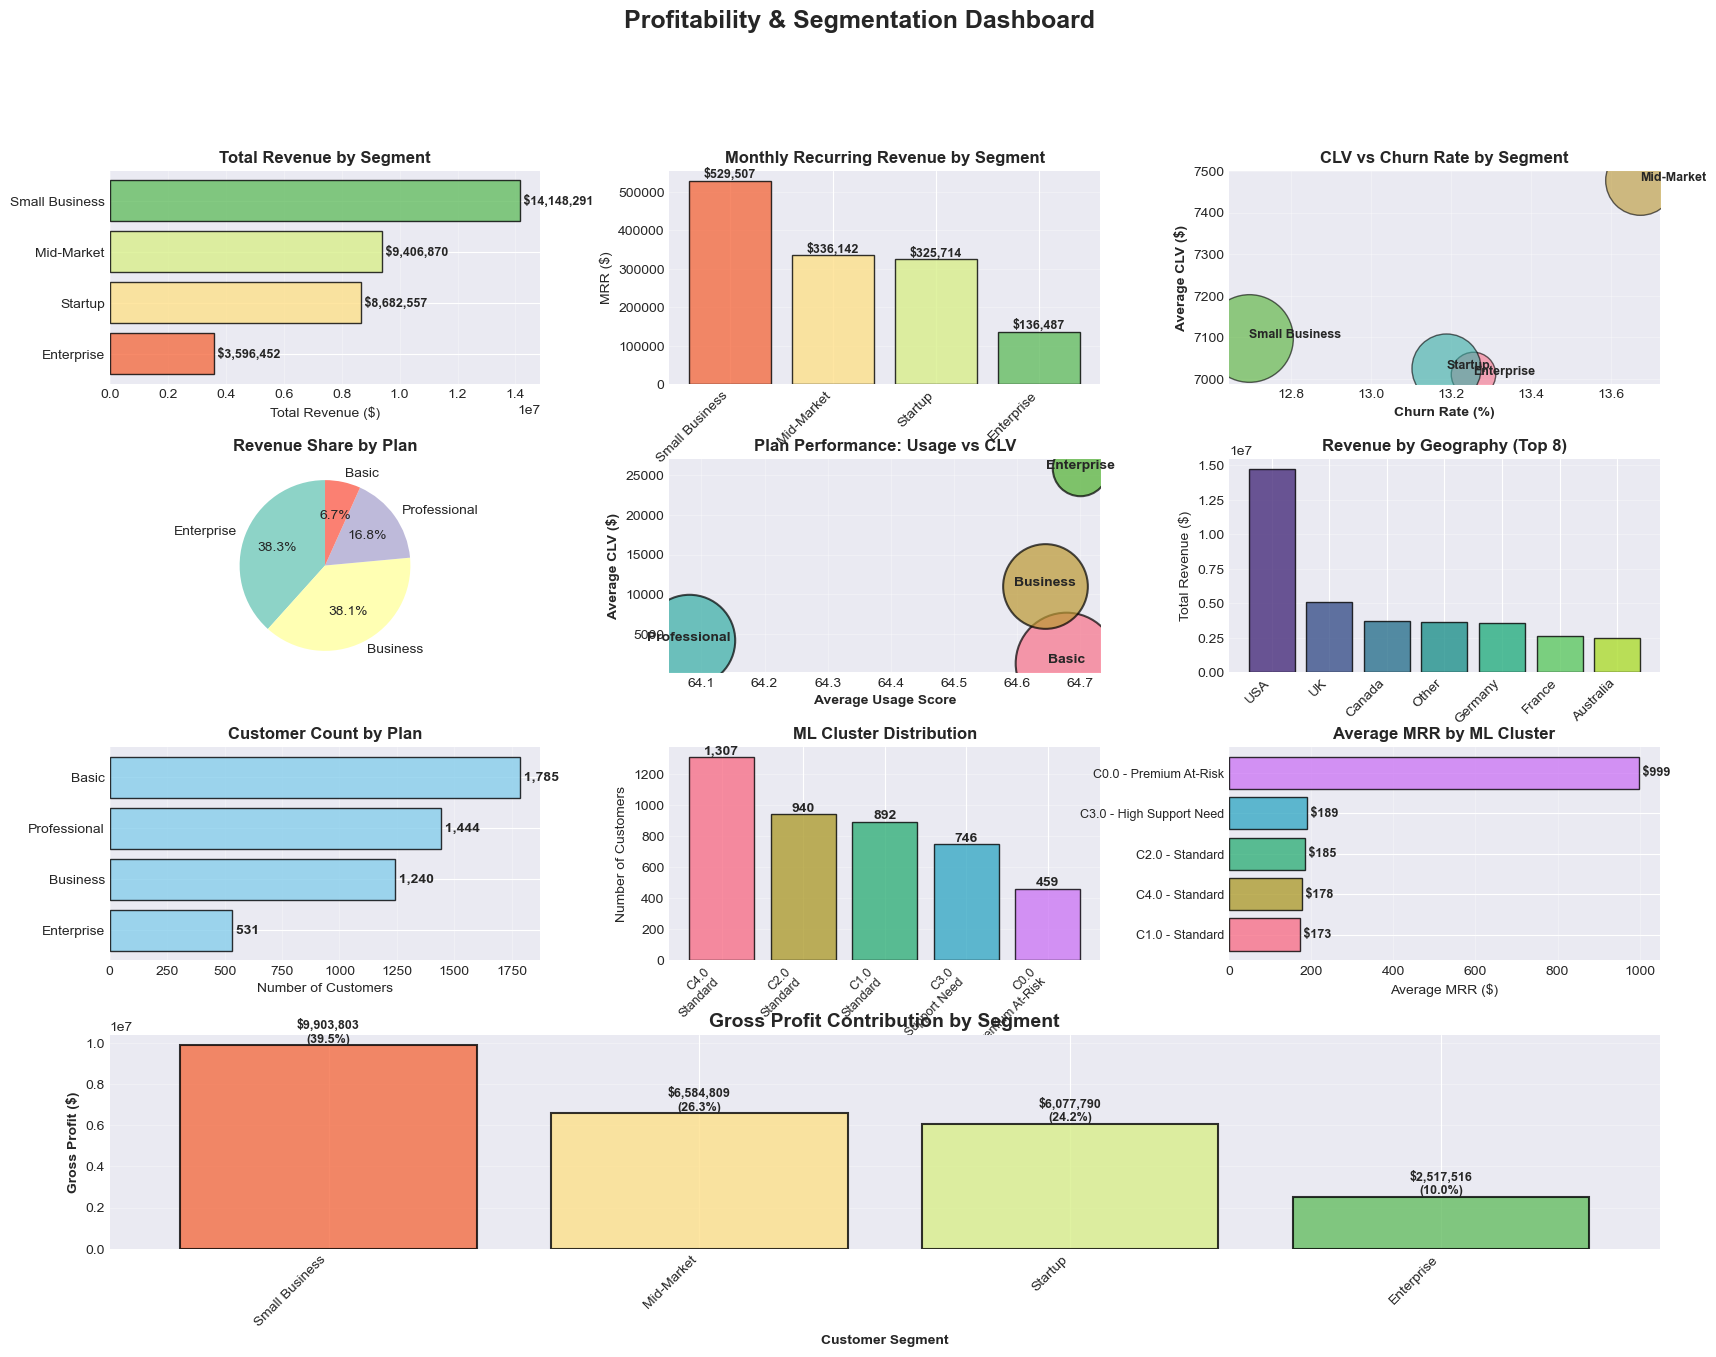


 Profitability Analysis Complete!



In [10]:
# ============================================================================
# SECTION 6: ADVANCED PROFITABILITY ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 6: PROFITABILITY & CUSTOMER SEGMENTATION")
print("="*80)

print("""
Advanced profitability analysis includes:
1. Customer segment profitability
2. Product/plan mix analysis
3. Geographic profitability
4. Customer acquisition efficiency
5. K-Means clustering for data-driven segments
""")

# ========================================================================
# 6.1: SEGMENT PROFITABILITY ANALYSIS
# ========================================================================

print("\n" + "-"*80)
print("6.1: CUSTOMER SEGMENT PROFITABILITY")
print("-"*80)

# Calculate profitability metrics by segment
profitability = customers.groupby('segment').agg({
    'customer_id': 'count',
    'mrr': 'sum',
    'total_revenue': ['sum', 'mean'],
    'clv': ['mean', 'sum'],
    'lifetime_months': 'mean',
    'is_churned': ['sum', 'mean']
})

profitability.columns = ['Customer_Count', 'Total_MRR', 'Total_Revenue', 
                        'Avg_Revenue', 'Avg_CLV', 'Total_CLV', 
                        'Avg_Lifetime', 'Churned_Count', 'Churn_Rate']

profitability['Churn_Rate'] = profitability['Churn_Rate'] * 100
profitability['Revenue_per_Customer_Month'] = profitability['Total_MRR'] / profitability['Customer_Count']

print("\n Profitability by Customer Segment:\n")
print(profitability.round(2))

# Calculate contribution margin (assuming costs)
# Hypothetical: 30% cost of service
profitability['Gross_Profit'] = profitability['Total_Revenue'] * 0.7
profitability['Profit_Margin_%'] = 70.0  # 70% margin

print("\n Profitability Summary:")
total_profit = profitability['Gross_Profit'].sum()
print(f"   • Total Gross Profit: ${total_profit:,.2f}")
print(f"   • Most Profitable Segment: {profitability['Gross_Profit'].idxmax()}")
print(f"   • Highest CLV Segment: {profitability['Avg_CLV'].idxmax()}")

# ========================================================================
# 6.2: PLAN MIX & PRICING ANALYSIS
# ========================================================================

print("\n" + "-"*80)
print("6.2: PLAN MIX & PRICING ANALYSIS")
print("-"*80)

plan_analysis = customers.groupby('plan').agg({
    'customer_id': 'count',
    'mrr': ['sum', 'mean'],
    'total_revenue': 'sum',
    'clv': 'mean',
    'is_churned': 'mean',
    'usage_score': 'mean',
    'nps_score': 'mean'
})

plan_analysis.columns = ['Customer_Count', 'Total_MRR', 'Avg_MRR', 
                        'Total_Revenue', 'Avg_CLV', 'Churn_Rate', 
                        'Avg_Usage', 'Avg_NPS']

plan_analysis['Churn_Rate'] = plan_analysis['Churn_Rate'] * 100
plan_analysis['Revenue_Share_%'] = (plan_analysis['Total_Revenue'] / 
                                     plan_analysis['Total_Revenue'].sum() * 100)

print("\n Plan Performance Analysis:\n")
print(plan_analysis.round(2))

# ========================================================================
# 6.3: GEOGRAPHIC PROFITABILITY
# ========================================================================

print("\n" + "-"*80)
print("6.3: GEOGRAPHIC PROFITABILITY ANALYSIS")
print("-"*80)

geo_analysis = customers.groupby('country').agg({
    'customer_id': 'count',
    'mrr': 'sum',
    'total_revenue': 'sum',
    'clv': 'mean',
    'is_churned': 'mean'
})

geo_analysis.columns = ['Customer_Count', 'Total_MRR', 'Total_Revenue', 
                       'Avg_CLV', 'Churn_Rate']
geo_analysis['Churn_Rate'] = geo_analysis['Churn_Rate'] * 100
geo_analysis = geo_analysis.sort_values('Total_Revenue', ascending=True)

print("\n Geographic Performance:\n")
print(geo_analysis.head(10).round(2))

# ========================================================================
# 6.4: K-MEANS CUSTOMER CLUSTERING
# ========================================================================

print("\n" + "-"*80)
print("6.4: DATA-DRIVEN CUSTOMER SEGMENTATION (K-Means)")
print("-"*80)

print("\nPerforming K-Means clustering on customer features...")

# Select features for clustering
clustering_features = ['mrr', 'lifetime_months', 'usage_score', 'nps_score', 
                      'transaction_count', 'support_tickets']

# Prepare data
cluster_data = customers[customers['is_churned'] == 0][clustering_features].copy()
cluster_data = cluster_data.fillna(cluster_data.median())

# Scale features
scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_data)

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("\nTesting different numbers of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

# Choose optimal K (let's use 5 for this analysis)
optimal_k = 5
print(f"\nUsing K={optimal_k} clusters for segmentation")

# Fit final model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(cluster_scaled)

# Add cluster labels to data
customers.loc[customers['is_churned'] ==0, 'ml_cluster'] = cluster_labels

# Analyze clusters
cluster_analysis = customers[customers['is_churned'] == 0].groupby('ml_cluster').agg({
    'customer_id': 'count',
    'mrr': ['mean', 'sum'],
    'clv': 'mean',
    'lifetime_months': 'mean',
    'usage_score': 'mean',
    'nps_score': 'mean',
    'transaction_count': 'mean',
    'support_tickets': 'mean'
})

cluster_analysis.columns = ['Count', 'Avg_MRR', 'Total_MRR', 'Avg_CLV', 
                           'Avg_Lifetime', 'Avg_Usage', 'Avg_NPS', 
                           'Avg_Transactions', 'Avg_Tickets']

print("\n Machine Learning Customer Clusters:\n")
print(cluster_analysis.round(2))

# Name clusters based on characteristics
def name_cluster(row):
    if row['Avg_MRR'] > cluster_analysis['Avg_MRR'].mean() * 1.5:
        if row['Avg_Usage'] > cluster_analysis['Avg_Usage'].mean():
            return 'Premium Engaged'
        else:
            return 'Premium At-Risk'
    elif row['Avg_Usage'] > cluster_analysis['Avg_Usage'].mean() * 1.2:
        return 'Highly Engaged'
    elif row['Avg_Tickets'] > cluster_analysis['Avg_Tickets'].mean() * 1.5:
        return 'High Support Need'
    else:
        return 'Standard'

cluster_names = cluster_analysis.apply(name_cluster, axis=1)
print("\n Cluster Names:")
for i, name in enumerate(cluster_names):
    print(f"   Cluster {i}: {name}")

# ========================================================================
# 6.5: PROFITABILITY VISUALIZATIONS
# ========================================================================

print("\n" + "-"*80)
print("6.5: PROFITABILITY VISUALIZATIONS")
print("-"*80)

fig = plt.figure(figsize=(20, 14))
gs = GridSpec(4, 3, figure=fig, hspace=0.35, wspace=0.3)

# 1. Revenue by Segment
ax1 = fig.add_subplot(gs[0, 0])
profitability_sorted = profitability.sort_values('Total_Revenue', ascending=True)
colors_prof = sns.color_palette("RdYlGn", len(profitability_sorted))
ax1.barh(range(len(profitability_sorted)), profitability_sorted['Total_Revenue'], 
         color=colors_prof, alpha=0.8, edgecolor='black')
ax1.set_yticks(range(len(profitability_sorted)))
ax1.set_yticklabels(profitability_sorted.index)
ax1.set_title('Total Revenue by Segment', fontweight='bold', fontsize=12)
ax1.set_xlabel('Total Revenue ($)')
for i, v in enumerate(profitability_sorted['Total_Revenue']):
    ax1.text(v, i, f' ${v:,.0f}', va='center', fontweight='bold', fontsize=9)
ax1.grid(axis='x', alpha=0.3)

# 2. MRR by Segment
ax2 = fig.add_subplot(gs[0, 1])
mrr_sorted = profitability.sort_values('Total_MRR', ascending=False)
ax2.bar(range(len(mrr_sorted)), mrr_sorted['Total_MRR'], 
        color=colors_prof, alpha=0.8, edgecolor='black')
ax2.set_xticks(range(len(mrr_sorted)))
ax2.set_xticklabels(mrr_sorted.index, rotation=45, ha='right')
ax2.set_title('Monthly Recurring Revenue by Segment', fontweight='bold', fontsize=12)
ax2.set_ylabel('MRR ($)')
for i, v in enumerate(mrr_sorted['Total_MRR']):
    ax2.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. CLV vs Churn Rate by Segment
ax3 = fig.add_subplot(gs[0, 2])
for segment in profitability.index:
    clv = profitability.loc[segment, 'Avg_CLV']
    churn = profitability.loc[segment, 'Churn_Rate']
    count = profitability.loc[segment, 'Customer_Count']
    ax3.scatter(churn, clv, s=count*2, alpha=0.6, label=segment, edgecolors='black', linewidth=1)
    ax3.annotate(segment, (churn, clv), fontsize=9, fontweight='bold')
ax3.set_xlabel('Churn Rate (%)', fontweight='bold')
ax3.set_ylabel('Average CLV ($)', fontweight='bold')
ax3.set_title('CLV vs Churn Rate by Segment', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3)

# 4. Plan Mix (Revenue Share)
ax4 = fig.add_subplot(gs[1, 0])
plan_revenue_share = plan_analysis['Revenue_Share_%'].sort_values(ascending=False)
colors_plan = sns.color_palette("Set3", len(plan_revenue_share))
ax4.pie(plan_revenue_share.values, labels=plan_revenue_share.index, autopct='%1.1f%%',
        colors=colors_plan, startangle=90)
ax4.set_title('Revenue Share by Plan', fontweight='bold', fontsize=12)

# 5. Plan Performance Matrix
ax5 = fig.add_subplot(gs[1, 1])
for plan in plan_analysis.index:
    x = plan_analysis.loc[plan, 'Avg_Usage']
    y = plan_analysis.loc[plan, 'Avg_CLV']
    count = plan_analysis.loc[plan, 'Customer_Count']
    ax5.scatter(x, y, s=count*3, alpha=0.7, edgecolors='black', linewidth=1.5)
    ax5.annotate(plan, (x, y), fontsize=10, fontweight='bold', ha='center')
ax5.set_xlabel('Average Usage Score', fontweight='bold')
ax5.set_ylabel('Average CLV ($)', fontweight='bold')
ax5.set_title('Plan Performance: Usage vs CLV', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)

# 6. Geographic Revenue Distribution
ax6 = fig.add_subplot(gs[1, 2])
geo_top = geo_analysis.nlargest(8, 'Total_Revenue')
colors_geo = sns.color_palette("viridis", len(geo_top))
ax6.bar(range(len(geo_top)), geo_top['Total_Revenue'], 
        color=colors_geo, alpha=0.8, edgecolor='black')
ax6.set_xticks(range(len(geo_top)))
ax6.set_xticklabels(geo_top.index, rotation=45, ha='right')
ax6.set_title('Revenue by Geography (Top 8)', fontweight='bold', fontsize=12)
ax6.set_ylabel('Total Revenue ($)')
ax6.grid(axis='y', alpha=0.3)

# 7. Customer Count by Plan
ax7 = fig.add_subplot(gs[2, 0])
plan_counts = plan_analysis.sort_values('Customer_Count', ascending=True)
ax7.barh(range(len(plan_counts)), plan_counts['Customer_Count'], 
         color='skyblue', alpha=0.8, edgecolor='black')
ax7.set_yticks(range(len(plan_counts)))
ax7.set_yticklabels(plan_counts.index)
ax7.set_title('Customer Count by Plan', fontweight='bold', fontsize=12)
ax7.set_xlabel('Number of Customers')
for i, v in enumerate(plan_counts['Customer_Count']):
    ax7.text(v, i, f' {v:,}', va='center', fontweight='bold')
ax7.grid(axis='x', alpha=0.3)

# 8. K-Means Clusters
ax8 = fig.add_subplot(gs[2, 1])
cluster_counts = cluster_analysis['Count'].sort_values(ascending=False)
colors_cluster = sns.color_palette("husl", len(cluster_counts))
ax8.bar(range(len(cluster_counts)), cluster_counts.values, 
        color=colors_cluster, alpha=0.8, edgecolor='black')
ax8.set_xticks(range(len(cluster_counts)))
ax8.set_xticklabels([f'C{i}\n{cluster_names[i]}' for i in cluster_counts.index], 
                     rotation=45, ha='right', fontsize=9)
ax8.set_title('ML Cluster Distribution', fontweight='bold', fontsize=12)
ax8.set_ylabel('Number of Customers')
for i, v in enumerate(cluster_counts.values):
    ax8.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')
ax8.grid(axis='y', alpha=0.3)

# 9. Cluster MRR Comparison
ax9 = fig.add_subplot(gs[2, 2])
cluster_mrr = cluster_analysis.sort_values('Avg_MRR', ascending=True)
ax9.barh(range(len(cluster_mrr)), cluster_mrr['Avg_MRR'], 
         color=colors_cluster, alpha=0.8, edgecolor='black')
ax9.set_yticks(range(len(cluster_mrr)))
ax9.set_yticklabels([f'C{i} - {cluster_names[i]}' for i in cluster_mrr.index], fontsize=9)
ax9.set_title('Average MRR by ML Cluster', fontweight='bold', fontsize=12)
ax9.set_xlabel('Average MRR ($)')
for i, v in enumerate(cluster_mrr['Avg_MRR']):
    ax9.text(v, i, f' ${v:.0f}', va='center', fontweight='bold', fontsize=9)
ax9.grid(axis='x', alpha=0.3)

# 10. Profitability Waterfall (Segment Contribution)
ax10 = fig.add_subplot(gs[3, :])
segments_profit = profitability.sort_values('Gross_Profit', ascending=False)
cumulative = 0
bar_positions = []
bar_heights = []
bar_colors = []

for i, (segment, profit) in enumerate(segments_profit['Gross_Profit'].items()):
    bar_positions.append(i)
    bar_heights.append(profit)
    bar_colors.append(sns.color_palette("RdYlGn", len(segments_profit))[i])
    cumulative += profit

bars = ax10.bar(bar_positions, bar_heights, color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax10.set_xticks(bar_positions)
ax10.set_xticklabels(segments_profit.index, rotation=45, ha='right')
ax10.set_title('Gross Profit Contribution by Segment', fontweight='bold', fontsize=14)
ax10.set_ylabel('Gross Profit ($)', fontweight='bold')
ax10.set_xlabel('Customer Segment', fontweight='bold')

# Add value labels
for i, (bar, value) in enumerate(zip(bars, bar_heights)):
    height = bar.get_height()
    ax10.text(bar.get_x() + bar.get_width()/2., height,
             f'${value:,.0f}\n({value/total_profit*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold', fontsize=9)

ax10.grid(axis='y', alpha=0.3)

plt.suptitle('Profitability & Segmentation Dashboard', fontsize=18, fontweight='bold', y=0.995)
plt.savefig('financial_viz/15_profitability_dashboard.png', dpi=300, bbox_inches='tight')
print("\n Saved: financial_viz/15_profitability_dashboard.png")
plt.show()

print("\n Profitability Analysis Complete!")
print("="*80 + "\n")

In [11]:
# ============================================================================
# SECTION 7: EXECUTIVE DASHBOARD & REPORTING
# ============================================================================

print("\n" + "="*80)
print("SECTION 7: EXECUTIVE DASHBOARD & COMPREHENSIVE REPORTING")
print("="*80)

print("\nCreating final executive dashboard...")

# ========================================================================
# 7.1: KEY METRICS SUMMARY
# ========================================================================

print("\n" + "-"*80)
print("7.1: KEY PERFORMANCE INDICATORS (KPIs)")
print("-"*80)

# Calculate key metrics
total_customers_current = len(customers)
active_customers_current = (customers['is_churned'] == 0).sum()
total_mrr_current = customers[customers['is_churned'] == 0]['mrr'].sum()
total_arr = total_mrr_current * 12
avg_revenue_per_account = customers['total_revenue'].mean()
total_revenue_all_time = transactions['amount'].sum()

# Recent growth (last 6 months vs previous 6 months)
recent_months = monthly_revenue.tail(6)
previous_months = monthly_revenue.tail(12).head(6)
revenue_growth_rate = ((recent_months['total_revenue'].mean() - 
                       previous_months['total_revenue'].mean()) / 
                       previous_months['total_revenue'].mean() * 100)

# Customer metrics
avg_clv_current = customers['clv'].mean()
median_clv_current = customers['clv'].median()
churn_rate_current = (customers['is_churned'].sum() / len(customers)) * 100

kpi_summary = f"""
╔══════════════════════════════════════════════════════════════════════════╗
║                     KEY PERFORMANCE INDICATORS                            ║
╚══════════════════════════════════════════════════════════════════════════╝

REVENUE METRICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Total All-Time Revenue         : ${total_revenue_all_time:,.2f}
  • Current Monthly MRR             : ${total_mrr_current:,.2f}
  • Annual Recurring Revenue (ARR)  : ${total_arr:,.2f}
  • Average Revenue per Account     : ${avg_revenue_per_account:,.2f}
  • Revenue Growth Rate (6mo)       : {revenue_growth_rate:+.2f}%
  
CUSTOMER METRICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Total Customers                 : {total_customers_current:,}
  • Active Customers                : {active_customers_current:,}
  • Churned Customers               : {total_customers_current - active_customers_current:,}
  • Overall Churn Rate              : {churn_rate_current:.2f}%
  • Average Customer Lifetime       : {customers['lifetime_months'].mean():.1f} months
  
CUSTOMER VALUE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Average CLV                     : ${avg_clv_current:,.2f}
  • Median CLV                      : ${median_clv_current:,.2f}
  • CLV to CAC Ratio                : {avg_clv_current / 500:.2f}x (assumed CAC: $500)
  • Average Payback Period          : {customers['payback_months'].mean():.1f} months

FORECASTING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Forecasted Revenue (Next 12mo)  : ${forecast.sum():,.2f}
  • Expected Monthly Average        : ${forecast.mean():,.2f}
  • Model Accuracy (MAPE)           : {mape:.2f}%

RISK METRICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • At-Risk Customers (>50% prob)   : {len(at_risk):,}
  • At-Risk MRR                     : ${at_risk_mrr:,.2f}
  • Potential Annual Revenue Loss   : ${at_risk_mrr * 12:,.2f}
"""

print(kpi_summary)

# Save KPI summary to file
with open('kpi_summary.txt', 'w') as f:
    f.write(kpi_summary)
print("Saved KPI summary to: 'kpi_summary.txt'")


# Work on your executive Summary; Take the example from Healthcare analytics project
print("\n Saved executive summary to: 'EXECUTIVE_SUMMARY_FINANCIAL.txt'")


SECTION 7: EXECUTIVE DASHBOARD & COMPREHENSIVE REPORTING

Creating final executive dashboard...

--------------------------------------------------------------------------------
7.1: KEY PERFORMANCE INDICATORS (KPIs)
--------------------------------------------------------------------------------

╔══════════════════════════════════════════════════════════════════════════╗
║                     KEY PERFORMANCE INDICATORS                            ║
╚══════════════════════════════════════════════════════════════════════════╝

REVENUE METRICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Total All-Time Revenue         : $35,834,169.55
  • Current Monthly MRR             : $1,160,806.00
  • Annual Recurring Revenue (ARR)  : $13,929,672.00
  • Average Revenue per Account     : $7,166.83
  • Revenue Growth Rate (6mo)       : +13.26%

CUSTOMER METRICS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Total Customers               

UnicodeEncodeError: 'charmap' codec can't encode characters in position 2-77: character maps to <undefined>

In [ ]:
# ========================================================================
# 7.3: CREATE FINAL COMPREHENSIVE DASHBOARD
# ========================================================================

print("\n" + "-"*80)
print("7.3: CREATING FINAL COMPREHENSIVE DASHBOARD")
print("-"*80)

fig = plt.figure(figsize=(24, 16))
gs = GridSpec(4, 4, figure=fig, hspace=0.4, wspace=0.3)

# Color scheme
colors_main = sns.color_palette("Set2", 8)

# 1. Revenue Trend with Forecast
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(ts_data.index, ts_data['total_revenue'], 
        linewidth=3, color='#3498db', marker='o', markersize=5, label='Historical', alpha=0.8)
ax1.plot(forecast_index, forecast, 
        linewidth=3, color='#2ecc71', marker='D', markersize=6, label='Forecast', linestyle='--')
ax1.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='#2ecc71', alpha=0.2)
ax1.set_title('Revenue Trend & 12-Month Forecast', fontweight='bold', fontsize=14)
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Revenue ($)', fontweight='bold')
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. KPI Scorecard
ax2 = fig.add_subplot(gs[0, 2:])
ax2.axis('off')
kpi_text = f"""
KEY PERFORMANCE INDICATORS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Total Revenue:        ${total_revenue_all_time/1e6:.1f}M
Current ARR:          ${total_arr/1e6:.1f}M
Active Customers:     {active_customers_current:,}
Churn Rate:           {churn_rate_current:.1f}%

Average CLV:          ${avg_clv_current:,.0f}
Revenue Growth:       {revenue_growth_rate:+.1f}%
At-Risk Customers:    {len(at_risk):,}
Forecast (12mo):      ${forecast.sum()/1e6:.1f}M
"""
ax2.text(0.1, 0.5, kpi_text, transform=ax2.transAxes, fontsize=13,
        verticalalignment='center', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# 3. Churn Risk Segmentation
ax3 = fig.add_subplot(gs[1, 0])
risk_dist = churn_model_data[churn_model_data['is_churned']==0]['risk_category'].value_counts()
colors_risk = ['#2ecc71', '#f39c12', '#e67e22', '#e74c3c']
wedges, texts, autotexts = ax3.pie(risk_dist.values, labels=risk_dist.index, 
                                     autopct='%1.1f%%', colors=colors_risk,
                                     startangle=90, textprops={'fontweight': 'bold'})
ax3.set_title('Customer Risk Distribution', fontweight='bold', fontsize=12)

# 4. Cohort Retention
ax4 = fig.add_subplot(gs[1, 1])
avg_retention_plot = avg_retention.iloc[:13]
ax4.plot(avg_retention_plot.index, avg_retention_plot.values, 
        marker='o', linewidth=3, markersize=8, color='#e74c3c')
ax4.fill_between(avg_retention_plot.index, avg_retention_plot.values, 
                 alpha=0.3, color='#e74c3c')
ax4.set_title('Average Cohort Retention', fontweight='bold', fontsize=12)
ax4.set_xlabel('Months Since Signup', fontweight='bold')
ax4.set_ylabel('Retention Rate (%)', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 105])

# 5. Segment Profitability
ax5 = fig.add_subplot(gs[1, 2:])
x_pos = np.arange(len(profitability))
width = 0.35
ax5.bar(x_pos - width/2, profitability['Total_Revenue']/1000, width, 
       label='Revenue', color='#3498db', alpha=0.8, edgecolor='black')
ax5.bar(x_pos + width/2, profitability['Gross_Profit']/1000, width,
       label='Gross Profit', color='#2ecc71', alpha=0.8, edgecolor='black')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(profitability.index, rotation=45, ha='right')
ax5.set_title('Revenue & Profit by Segment ($K)', fontweight='bold', fontsize=12)
ax5.set_ylabel('Amount ($K)', fontweight='bold')
ax5.legend(loc='upper right')
ax5.grid(axis='y', alpha=0.3)

# 6. RFM Segments
ax6 = fig.add_subplot(gs[2, 0])
rfm_counts = rfm_summary['Count'].sort_values(ascending=True)
colors_rfm = sns.color_palette("Spectral", len(rfm_counts))
ax6.barh(range(len(rfm_counts)), rfm_counts.values, color=colors_rfm, 
        alpha=0.8, edgecolor='black')
ax6.set_yticks(range(len(rfm_counts)))
ax6.set_yticklabels(rfm_counts.index, fontsize=9)
ax6.set_title('RFM Customer Segments', fontweight='bold', fontsize=12)
ax6.set_xlabel('Customer Count', fontweight='bold')
for i, v in enumerate(rfm_counts.values):
    ax6.text(v, i, f' {v:,.0f}', va='center', fontweight='bold', fontsize=8)
ax6.grid(axis='x', alpha=0.3)

# 7. Plan Performance
ax7 = fig.add_subplot(gs[2, 1])
plan_clv = plan_analysis.sort_values('Avg_CLV', ascending=False)
colors_plan = sns.color_palette("coolwarm", len(plan_clv))
ax7.bar(range(len(plan_clv)), plan_clv['Avg_CLV'], color=colors_plan, 
       alpha=0.8, edgecolor='black')
ax7.set_xticks(range(len(plan_clv)))
ax7.set_xticklabels(plan_clv.index, rotation=45, ha='right')
ax7.set_title('Average CLV by Plan', fontweight='bold', fontsize=12)
ax7.set_ylabel('Average CLV ($)', fontweight='bold')
for i, v in enumerate(plan_clv['Avg_CLV']):
    ax7.text(i, v, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
ax7.grid(axis='y', alpha=0.3)

# 8. Churn Probability Distribution
ax8 = fig.add_subplot(gs[2, 2:])
active_probs = churn_model_data[churn_model_data['is_churned']==0]['churn_probability']
ax8.hist(active_probs, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax8.axvline(x=0.5, color='red', linestyle='--', linewidth=3, label='Risk Threshold')
ax8.axvline(x=active_probs.mean(), color='green', linestyle='--', linewidth=3,
           label=f'Mean: {active_probs.mean():.2f}')
ax8.set_title('Churn Probability Distribution (Active Customers)', 
             fontweight='bold', fontsize=12)
ax8.set_xlabel('Churn Probability', fontweight='bold')
ax8.set_ylabel('Number of Customers', fontweight='bold')
ax8.legend(loc='upper right')
ax8.grid(axis='y', alpha=0.3)

# 9. Geographic Distribution
ax9 = fig.add_subplot(gs[3, 0])
geo_top5 = geo_analysis.nlargest(5, 'Total_Revenue')
ax9.pie(geo_top5['Total_Revenue'], labels=geo_top5.index, autopct='%1.1f%%',
       colors=sns.color_palette("Set3", len(geo_top5)), startangle=90)
ax9.set_title('Revenue by Geography (Top 5)', fontweight='bold', fontsize=12)

# 10. ML Clusters Value
ax10 = fig.add_subplot(gs[3, 1])
cluster_value = cluster_analysis.sort_values('Total_MRR', ascending=True)
ax10.barh(range(len(cluster_value)), cluster_value['Total_MRR'], 
         color=sns.color_palette("husl", len(cluster_value)), alpha=0.8, edgecolor='black')
ax10.set_yticks(range(len(cluster_value)))
ax10.set_yticklabels([f'C{i}' for i in cluster_value.index], fontsize=9)
ax10.set_title('Total MRR by ML Cluster', fontweight='bold', fontsize=12)
ax10.set_xlabel('Total MRR ($)', fontweight='bold')
for i, v in enumerate(cluster_value['Total_MRR']):
    ax10.text(v, i, f' ${v:,.0f}', va='center', fontweight='bold', fontsize=8)
ax10.grid(axis='x', alpha=0.3)

# 11. Feature Importance (Churn)
ax11 = fig.add_subplot(gs[3, 2:])
top_features_plot = feature_importance.head(10)
ax11.barh(range(len(top_features_plot)), top_features_plot['importance'],
         color='coral', alpha=0.8, edgecolor='black')
ax11.set_yticks(range(len(top_features_plot)))
ax11.set_yticklabels(top_features_plot['feature'], fontsize=9)
ax11.set_title('Top 10 Churn Predictors', fontweight='bold', fontsize=12)
ax11.set_xlabel('Feature Importance', fontweight='bold')
ax11.grid(axis='x', alpha=0.3)
ax11.invert_yaxis()

# Overall title
plt.suptitle('Financial Operations Analytics - Executive Dashboard', 
            fontsize=20, fontweight='bold', y=0.998)

plt.savefig('financial_viz/16_FINAL_EXECUTIVE_DASHBOARD.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: financial_viz/16_FINAL_EXECUTIVE_DASHBOARD.png")
plt.show()

print("\n✅ Executive Dashboard Complete!")
print("="*80 + "\n")